# N-body simulations

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

# save_dir = Path("./")
save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test21")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/lpt_64_fnl_0")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CpuDevice(id=0)]


/local/home/hs276503/miniforge3/envs/testenv2/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


dphppce115.extra.cea.fr


PermissionError: [Errno 13] Permission denied: '/feynman'

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Compensation

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint
from jaxpm.growth import growth_factor
kpks = []
a_obs = 1.

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh

for mesh_length in [64, 128, 256]:
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            a_lpt = 0.1 if pm else a_obs
            config = {
                        'mesh_shape':3 * (mesh_length,),
                        'box_shape':3 * (640.,),
                        'a_lpt':a_lpt,
                        'a_obs':a_obs,
                        'lpt_order':lpt_order,
                        'precond':0,
                        'obs':'mesh'
                        }
            model = FieldLevelModel(**default_config | config)

            cosmology = Planck18()
            pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
            linmesh = jr.normal(jr.key(0), model.mesh_shape)
            linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
            init = {'init_mesh':linmesh}
            params = cosmology, init

            mesh = evolve(model, params)
            kpk = model.spectrum(mesh, deconv=True)
            kpks.append(kpk)

            D1 = growth_factor(cosmology, jnp.atleast_1d(a_obs))
            kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
            kpks.append(kpklin)

ImportError: cannot import name 'lpt' from 'montecosmo.bricks' (/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/bricks.py)

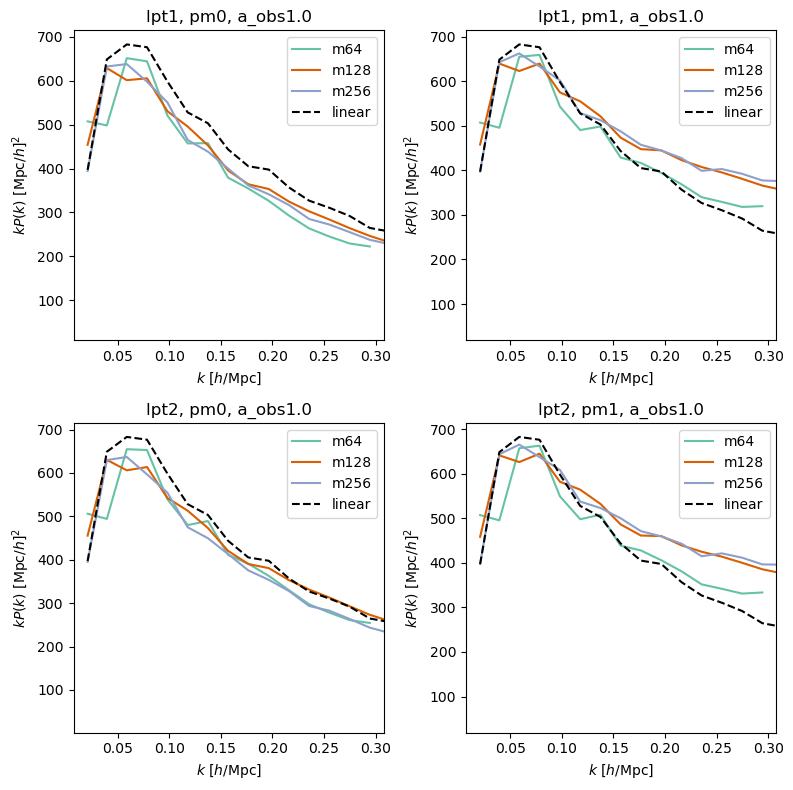

In [11]:
from montecosmo.plot import plot_pow, plot_trans, theme
theme()

plt.figure(figsize=(8, 8))
i_count = 0
for mesh_length in [64, 128, 256]:
    i_plt = 0
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            kpk = kpks[i_count]
            kpklin = kpks[i_count+1]

            plt.subplot(2, 2, i_plt+1)
            plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

            # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')
            
            plot_pow(*kpk, label=f'm{mesh_length}')
            if i_count>15:
                plot_pow(*kpklin, 'k--', label='linear')
            
            plt.xlim(*plt.xlim())
        
            plt.legend()
            i_count += 2
            i_plt += 1
plt.tight_layout()

## Gaussianity

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint, rfftk
from jaxpm.growth import growth_factor

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh


config = {
            'mesh_shape':3 * (256,),
            'box_shape':3 * (10000.,),
            'a_lpt':0.1,
            'a_obs':1.,
            'lpt_order':2,
            'precond':0,
            'obs':'mesh'
            }
model = FieldLevelModel(**default_config | config)

cosmology = Planck18()
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
seed = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(seed) * pmeshk**.5
params = cosmology, {'init_mesh':linmesh}

mesh = evolve(model, params) - 1
k, pk = model.spectrum(mesh, deconv=True)

pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, jnp.log(pk), left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
kvec = rfftk(model.mesh_shape)
k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, model.mesh_shape, model.box_shape))**0.5
pmeshk = pk_fn(k_box) * (model.mesh_shape / model.box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units
gaussmesh = jnp.fft.irfftn(jnp.fft.rfftn(seed) * pmeshk**.5)

D1 = growth_factor(cosmology, jnp.atleast_1d(model.a_obs))
linmesh = jnp.fft.irfftn(linmesh * D1)

ImportError: cannot import name 'lpt' from 'montecosmo.bricks' (/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/bricks.py)

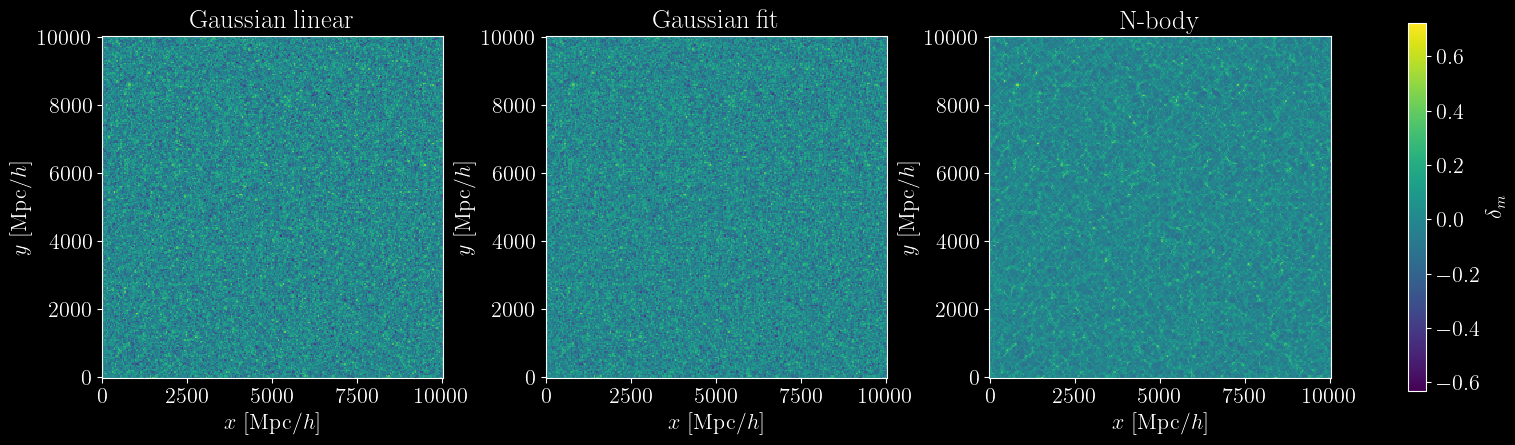

In [11]:
from montecosmo.plot import plot_mesh, theme
dark = True
theme(dark=dark, usetex=True, font_size=16)


mesh_toplot = jnp.stack([linmesh, gaussmesh, mesh])
vlim = 1e-2*5
vlim = jnp.array([vlim/2, 1-vlim/2])
vlim = jnp.quantile(mesh_toplot, vlim)
sli = 1/20

titles = ['Gaussian linear', 'Gaussian fit', 'N-body']

plt.figure(figsize=(17, 5))
for i_plt, m in enumerate(mesh_toplot):
    plt.subplot(1, 3, i_plt+1)
    plt.title(titles[i_plt])
    plot_mesh(m, model.box_shape, sli=sli, vlim=vlim)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.colorbar(ax=plt.gcf().axes).set_label("$\\delta_m$")
fina = f'gaussinity_b{model.box_shape[0]:.0f}'
if dark: fina += '_dk'
plt.savefig(fina+'.png', dpi=200)

## BullFrog

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, rsd as rsd_bf, los_pos, radius_pos, chi2a
from montecosmo.nbody import lpt_fpm, nbody_tsit5, nbody_bf, nbody_bf_scan, rsd_fpm, lpt
from jaxpm.painting import cic_paint
from montecosmo.nbody import a2g, a2f
import jax_cosmo as jc

a_obs = .5
a_lpt = 0.005 
# a_lpt = a_obs
solvers = ['bullfrog', 'tsit5']
mesh_length, box_length = 64, 320.
lpt_order = 2
grad_fd = False
rsd = True

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_obs':a_obs,
            'lpt_order':lpt_order,
            'precond':'kaiser',
            'observable':'field',
            'curved_sky':False,
            'box_center': (0.,0.,1.),
            }

def evolve(model, params:tuple, solver='bullfrog', grad_fd=False, lap_fd=False, 
           rsd=False, n_steps=50, tol=1e-5, a_lpt=0.1): # grad_fd=False, lap_fd=False, no deconv, for pmwd
    cosmology, init = params

    # Create regular grid of particles
    pos = jnp.indices(model.mesh_shape, dtype=float).reshape(3,-1).T

    if solver == 'bullfrog':
        cosmology._workspace = {}  # HACK: temporary fix

        part = nbody_bf(cosmology, **init, pos=pos, a=model.a_obs, n_steps=n_steps, grad_fd=grad_fd, lap_fd=lap_fd)
        pos, vel = tree.map(lambda x: x[-1], part)

        # dpos, vel = lpt(cosmology, **init, pos=pos, a=model.a_obs, order=model.lpt_order, grad_fd=False, lap_fd=False)
        # pos += dpos

        los = los_pos(pos, model.box_center, model.box_shape, model.mesh_shape, model.curved_sky)

        if rsd:
            # RSD displacement at a_obs
            pos += rsd_bf(cosmology, model.a_obs, vel, los=los)
            vel = vel * a2g(cosmology, model.a_obs) * a2f(cosmology, model.a_obs)
        else: 
            vel = None

    elif solver == 'tsit5':
        # LPT displacement at a_lpt
        # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
        cosmology._workspace = {}  # HACK: temporary fix
        
        dpos, vel = lpt_fpm(cosmology, **init, pos=pos, a=a_lpt, order=model.lpt_order, grad_fd=grad_fd, lap_fd=lap_fd)
        part = (pos + dpos, vel)

        # # PM displacement from a_lpt to a_obs
        # part = nbody_tsit5(cosmology, model.mesh_shape, part, a_lpt, model.a_obs, 
        #                         tol=tol, grad_fd=grad_fd, lap_fd=lap_fd)
        # part = tree.map(lambda x: x[-1], part)
        pos, vel = part

        los = los_pos(pos, model.box_center, model.box_shape, model.mesh_shape, model.curved_sky)

        if rsd==2:
            rpos = radius_pos(pos, model.box_center, model.box_shape, model.mesh_shape, model.curved_sky)
            vel = vel / (jc.background.Esqr(cosmology, model.a_obs)**.5 * model.a_obs**2)


        elif rsd:
            # RSD displacement at a_obs
            pos += rsd_fpm(cosmology, model.a_obs, vel, los=los)
            vel = vel / (jc.background.Esqr(cosmology, model.a_obs)**.5 * model.a_obs**2)
        else: 
            vel = None

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), pos)
    return biased_mesh, vel

### Growth functions

2025-04-20 22:50:50.237564: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


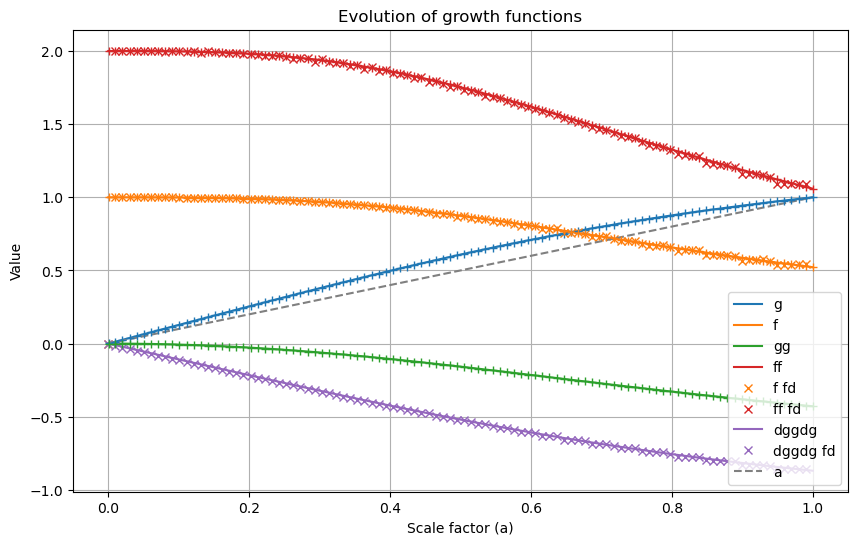

In [3]:
from jaxpm.growth import growth_factor as g, growth_rate as f, growth_factor_second as gg, growth_rate_second as ff
from montecosmo.bricks import Planck18
cosmo = Planck18()
a = jnp.linspace(0., 1, 100)
# gs = g(cosmo, a)
f_values = f(cosmo, a)
gg_values = gg(cosmo, a)*(-3/7)
ff_values = ff(cosmo, a)
from montecosmo.nbody import g2a, g2gg, g2f, g2ff, a2g
cosmo = Planck18()
gs = a2g(cosmo, a)
aa = g2a(cosmo, gs)
fs = g2f(cosmo, gs)
ggs = g2gg(cosmo, gs)
ffs = g2ff(cosmo, gs)

dg = jnp.diff(jnp.log(gs))/jnp.diff(jnp.log(a))
dgg = jnp.diff(jnp.log(gg_values*-1))/jnp.diff(jnp.log(a))

def dggdg(cosmo, g):
    gg, f, ff = g2gg(cosmo, g), g2f(cosmo, g), g2ff(cosmo, g)
    return jnp.where(g==0., 0., gg * ff / (g * f))
dggdgs_fd = jnp.diff(gg_values)/jnp.diff(gs)
dggdgs = dggdg(cosmo, gs)

plt.figure(figsize=(10, 6))
plt.plot(a, gs, 'C0', label='g')
plt.plot(a, f_values, 'C1', label='f')
plt.plot(a, gg_values, 'C2', label='gg')
plt.plot(a, ff_values, 'C3', label='ff')

plt.plot(a[:-1], dg, 'C1x', label='f fd')
plt.plot(a[:-1], dgg, 'C3x', label='ff fd')

plt.plot(a, dggdgs, 'C4', label='dggdg')
plt.plot(a[:-1], dggdgs_fd, 'C4x', label='dggdg fd')

plt.plot(a, a, '--', c='grey', label='a')
plt.plot(aa, gs, 'C0+')
plt.plot(aa, fs, 'C1+')
plt.plot(aa, ggs, 'C2+')
plt.plot(aa, ffs, 'C3+')
plt.xlabel('Scale factor (a)')
plt.ylabel('Value')
plt.legend()
plt.title('Evolution of growth functions')
plt.grid(True)
plt.show()

### PMWD comparison

In [15]:
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody as nbody_pmwd, lpt as lpt_pmwd
import jax
import jax_cosmo as jc


def run_pmwd(cosmo=(0.2607, 0.8102), a_lpt=.1, a_obs=1., lpt_order=1, rsd=False, box_length=640., mesh_length=256, n_steps=64, pmeshk=None):
    ptcl_spacing = box_length / mesh_length # Mpc/h
    ptcl_grid_shape = (mesh_length,)*3
    mesh_shape = np.array((mesh_length,)*3)
    box_shape = np.array((box_length,)*3)
    zeros_mesh = jnp.zeros(mesh_shape)
    
    # jax.config.update("jax_enable_x64", False)
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=lpt_order,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=(a_obs - a_lpt) / n_steps)
    Omega_c, sigma8 = cosmo
    Omega_b = 0.0490
    # XXX: sigma8 redshift dependant???
    cosmo = Cosmology.from_sigma8(conf, sigma8=sigma8, n_s=0.9665, Omega_m=Omega_c+Omega_b, Omega_b=Omega_b, h=0.6766)
    # cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    # cosmo = Cosmology(conf, A_s_1e9=sigma8**2, n_s=0.9665, Omega_m=Omega_c+Omega_b, Omega_b=Omega_b, h=0.6766)
    cosmo = boltzmann(cosmo, conf)

    cosmology = Planck18(Omega_c=Omega_c, sigma8=sigma8)
    if pmeshk is None:
        pmeshk = lin_power_mesh(cosmology, mesh_shape, box_shape)
    init_modes = jr.normal(jr.key(0), mesh_shape)
    init_modes = jnp.fft.rfftn(init_modes) * pmeshk**.5

    init_modes *= a2g(cosmology, jnp.atleast_1d(a_lpt)) / growth(a_lpt, cosmo, conf, order=1) * conf.ptcl_cell_vol
    ptcl, obsvbl = lpt_pmwd(init_modes, cosmo, conf)
    # return ptcl.disp/ptcl_spacing

    # modes = white_noise(0, conf)
    # field = jr.normal(jr.key(0), mesh_shape)
    # modes = jnp.fft.rfftn(field, norm="ortho")
    # modes = linear_modes(modes, cosmo, conf)        
    # ptcl, obsvbl = lpt_pmwd(modes, cosmo, conf)
    
    ptcl, obsvbl = nbody_pmwd(ptcl, obsvbl, cosmo, conf)
    # jax.config.update("jax_enable_x64", False)
    vel = ptcl.vel / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
    if rsd:
        pos = ptcl.pos() + vel * jnp.array([0,0,1])
    else:
        pos = ptcl.pos()
    
    # return scatter(ptcl, conf)
    return cic_paint(zeros_mesh, pos/ptcl_spacing), vel/ptcl_spacing

In [ ]:
import time
solvers = ['bullfrog', 'tsit5', 'pmwd']
model = FieldLevelModel(**default_config | config)
print(model)

cosmo = jnp.array([0.2607, 0.8102])
Omega_c, sigma8 = cosmo
cosmology = Planck18(Omega_c=Omega_c, sigma8=sigma8)
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
linmesh = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
init = {'init_mesh':linmesh}
params = cosmology, init

D1 = a2g(cosmology, a_obs)
linmesh = jnp.fft.irfftn(linmesh * D1)
kpklin = model.spectrum(linmesh)

# jax.config.update("jax_enable_x64", False)
start_time = time.time()
mesh_pmwd, dx_pmwd = run_pmwd(cosmo=cosmo, a_lpt=a_lpt, a_obs=a_obs, lpt_order=lpt_order, n_steps=20, rsd=rsd, box_length=box_length, mesh_length=mesh_length)
print(f'pmwd time: {time.time()-start_time:.2f}s')

start_time = time.time()
mesh_ts, dx_ts = evolve(model, params, solver='tsit5', grad_fd=grad_fd, lap_fd=False, rsd=rsd, a_lpt=a_lpt)
print(f'tsit5 time: {time.time()-start_time:.2f}s')

start_time = time.time()
mesh_bf, dx_bf = evolve(model, params, solver='bullfrog', n_steps=20, grad_fd=grad_fd, lap_fd=False, rsd=rsd, a_lpt=a_lpt)
print(f'bullfrog time: {time.time()-start_time:.2f}s')
# jax.config.update("jax_enable_x64", False)

ref = linmesh
comp = (0, 2)

# ref = mesh_bf
# comp = 2

kptcs = []
kptc = model.powtranscoh(ref, mesh_bf, deconv=comp)
kptcs.append(kptc)
kptc = model.powtranscoh(ref, mesh_ts, deconv=comp)
kptcs.append(kptc)
kptc = model.powtranscoh(ref, mesh_pmwd, deconv=comp)
kptcs.append(kptc)

mses = []
mse = jnp.mean((ref - mesh_bf)**2)
mses.append(mse)
mse = jnp.mean((ref - mesh_ts)**2)
mses.append(mse)
mse = jnp.mean((ref - mesh_pmwd)**2)
mses.append(mse)

# CONFIG
{'a_obs': 0.5,
 'box_center': array([0., 0., 1.]),
 'box_shape': array([320., 320., 320.]),
 'curved_sky': False,
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.02},
             'bn2': {'group': 'bias',
                     'lab

[2.394 2.316 2.327]


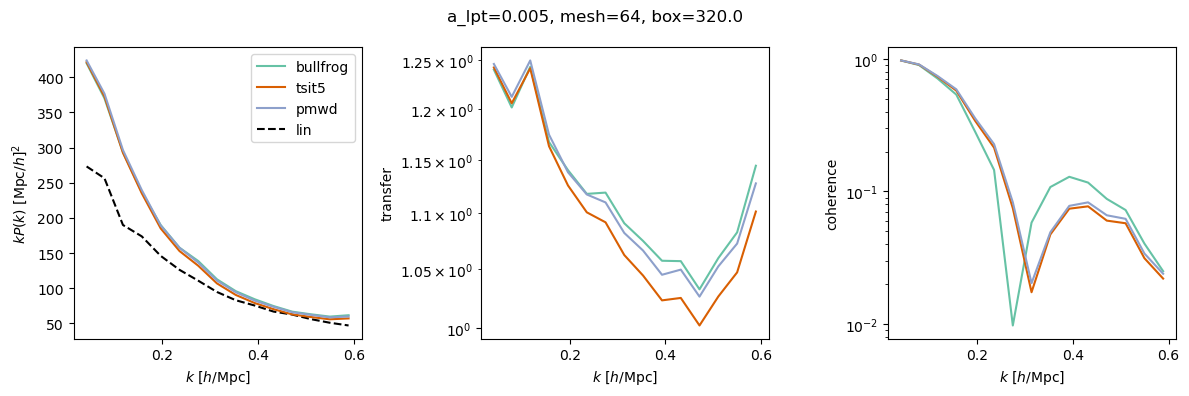

In [17]:
from montecosmo.plot import plot_powtranscoh, plot_pow, theme, SetDark2
theme()
log = False

plt.figure(figsize=(12,4))
for i_plt, kptc in enumerate(kptcs):
    plot_powtranscoh(*kptc, log=log, label=f"{solvers[i_plt]}")
plt.subplot(1,3,1)
plot_pow(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()
plt.suptitle(f"{a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_gradfd{grad_fd:d}_rsd{rsd:d}.png', dpi=200)
print(np.array(mses))

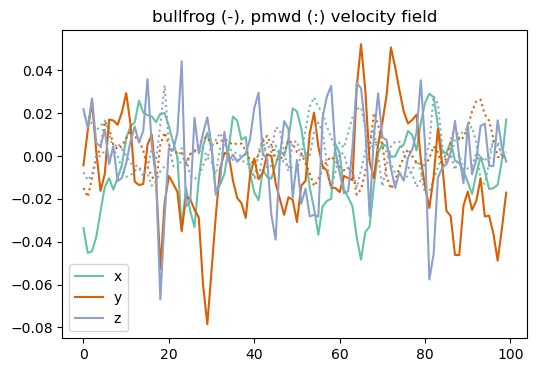

In [30]:
i_plt = 100
plt.figure(figsize=(6, 4))
for i_c, coord in enumerate(['x', 'y', 'z']):
    loss = lambda x: (x - dx_ts[:i_plt, i_c])
    plt.plot(loss(dx_bf[:i_plt, i_c]) , c=SetDark2(i_c), label=coord)
    plt.plot(loss(dx_pmwd[:i_plt, i_c]), ':', c=SetDark2(i_c))
plt.title(f"{solvers[0]} (-), {solvers[2]} (:) velocity field")
plt.legend()
plt.show()

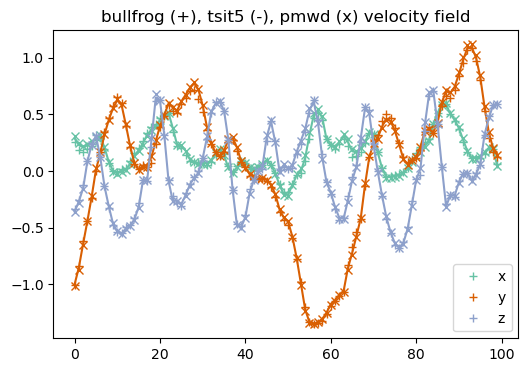

In [31]:
i_plt = 100
plt.figure(figsize=(6, 4))
for i_c, coord in enumerate(['x', 'y', 'z']):
    plt.plot(dx_ts[:i_plt, i_c], '-', c=SetDark2(i_c))
    plt.plot(dx_bf[:i_plt, i_c], '+', c=SetDark2(i_c), label=coord)
    plt.plot(dx_pmwd[:i_plt, i_c], 'x', c=SetDark2(i_c))
plt.title(f"{solvers[0]} (+), {solvers[1]} (-), {solvers[2]} (x) velocity field")
plt.legend()
plt.show()

### Temporal convergence

In [ ]:
import time
kptcs = []
a_obs = 1.
a_lpt = 1e-2
# solvers = ['bullfrog', 'tsit5']
solvers = ['tsit5', 'bullfrog']
# solvers = ['bullfrog']
mesh_length = 256
box_length = 640.
sli = slice(0, -1)
tols =  [1e-7, 1e-5, 1e-3, 1e-1, 1e4][sli]
# nstps = 6*np.array([94, 18, 8, 5, 3])[sli] # 6 evals per dopri5/tsit5 steps
nstps = np.array([94, 18, 8, 5, 3])[sli] # 6 evals per dopri5/tsit5 steps
# nstps = round(jnp.linspace(10, 100, 5))[::-1]

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_obs':a_obs,
            'lpt_order':2,
            'precond':'kaiser',
            'observable':'field'
            }
model = FieldLevelModel(**default_config | config)
cosmology = Planck18()
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
linmesh = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
init = {'init_mesh':linmesh}
params = cosmology, init

i_count = 0
for nstp, tol in zip(nstps, tols):
    for solver in solvers:
        start_time = time.time()
        mesh, moment = evolve(model, params, solver=solver, grad_fd=False, lap_fd=False, n_steps=nstp, tol=tol, a_lpt=a_lpt)
        print(f'{solver} time: {time.time()-start_time:.2f}s')
        if i_count == 0:
            print(f"{solver} as ref")
            D1 = growth_factor(cosmology, a_obs)
            linmesh = jnp.fft.irfftn(linmesh * D1)
            kpklin = model.spectrum(linmesh)
            mesh_ref = mesh
            comp = 2
            # mesh_ref = linmesh
            # comp = (0, 2)
        i_count+=1

        kptc = model.powtranscoh(mesh_ref, mesh, deconv=comp)
        kptcs.append(kptc)

tsit5 n_steps: 94
tsit5 time: 27.97s
tsit5 as ref
bullfrog time: 4.64s
tsit5 n_steps: 18
tsit5 time: 8.27s
bullfrog time: 3.10s
tsit5 n_steps: 8
tsit5 time: 5.58s
bullfrog time: 2.92s
tsit5 n_steps: 5
tsit5 time: 4.89s
bullfrog time: 2.85s


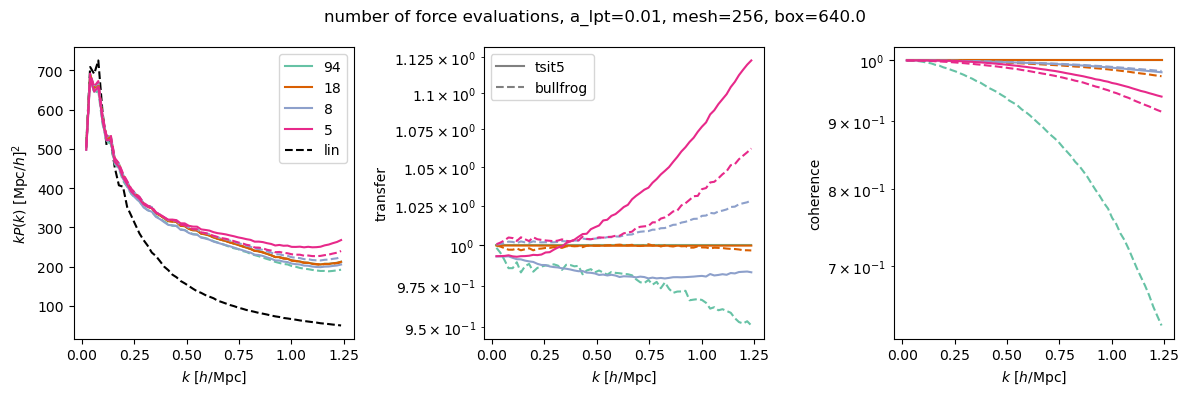

In [13]:
from montecosmo.plot import plot_powtranscoh, plot_pow, theme, SetDark2
theme()
log = False
plt.figure(figsize=(12,4))
i_count = 0
lss = ['-', '--']
for i_c, (nstp, tol) in enumerate(zip(nstps, tols)):
    plot_powtranscoh(*kptcs[i_count], lss[0], log=log, c=SetDark2(i_c), label=f"{nstp}")
    plot_powtranscoh(*kptcs[i_count+1], lss[1], log=log, c=SetDark2(i_c))
    i_count+=len(solvers)
plt.subplot(1,3,1)
plot_pow(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()

from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_m, (ls, solver) in enumerate(zip(lss, solvers)):
    handles.append(Line2D([], [], color='grey', linestyle=ls, label=solver))
plt.subplot(132)
plt.legend(handles=handles)
plt.suptitle(f"number of force evaluations, {a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_nsteps.png', dpi=200)

### Spatial convergence

In [ ]:
import time

kpks = []
a_obs = 1.
solvers = ['bullfrog', 'tsit5']
lengths = [64, 128, 256]
lpt_orders = [2]
pms = [1]

for solver in solvers:
    for mesh_length in lengths:
        for lpt_order in lpt_orders:
            for pm in pms:
                a_lpt = 0.001 if pm else a_obs
                config = {
                            'mesh_shape':3 * (mesh_length,),
                            'box_shape':3 * (640.,),
                            'a_lpt':a_lpt,
                            'a_obs':a_obs,
                            'lpt_order':lpt_order,
                            'precond':0,
                            'obs':'mesh'
                            }
                model = FieldLevelModel(**default_config | config)

                cosmology = Planck18()
                pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
                linmesh = jr.normal(jr.key(0), model.mesh_shape)
                linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
                init = {'init_mesh':linmesh}
                params = cosmology, init

                start_time = time.time()
                mesh = evolve(model, params, solver=solver, grad_fd=False, lap_fd=False).block_until_ready()
                print(f'{solver} time: {time.time()-start_time:.2f}s')
                kpk = model.spectrum(mesh, deconv=True)
                kpks.append(kpk)

                D1 = growth_factor(cosmology, a_obs)
                kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
                kpks.append(kpklin)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 0.76s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 0.79s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 1.17s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 6
tsit5 time: 2.16s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 7
tsit5 time: 1.26s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 12
tsit5 time: 3.09s


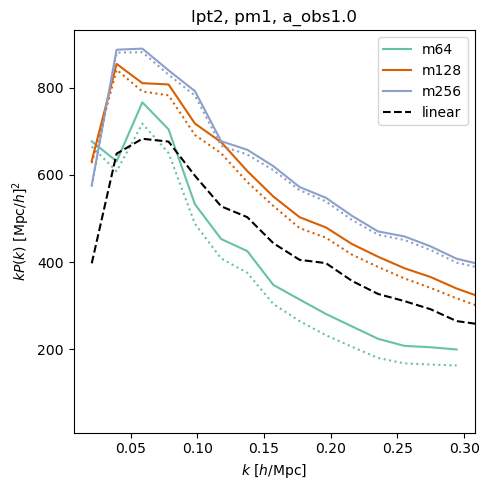

In [93]:
from montecosmo.plot import plot_pow, plot_trans, theme, SetDark2
theme()

plt.figure(figsize=(5, 5))
i_count = 0
for i_s, solver in enumerate(solvers):
    for i_c, mesh_length in enumerate(lengths):
        i_plt = 0
        for lpt_order in lpt_orders:
            for pm in pms:
                kpk = kpks[i_count]
                kpklin = kpks[i_count+1]

                plt.subplot(len(lpt_orders), len(pms), i_plt+1)
                plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

                style = '-' if solver == 'bullfrog' else ':'
                label = f'm{mesh_length}' if solver == 'bullfrog' else None

                # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')

                plot_pow(*kpk, style, c=SetDark2(i_c), label=label)
                if i_c==len(lengths)-1 and i_s==len(solvers)-1:
                    plot_pow(*kpklin, 'k--', label='linear')
                
                plt.xlim(*plt.xlim())
            
                plt.legend()
                i_count += 2
                i_plt += 1
plt.tight_layout()
# plt.savefig(f'pmsolvers_resol_nodeconv_gradfd1.png', dpi=200)

### Gradients

In [47]:
from jax import value_and_grad
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody as nbody_pmwd, lpt as lpt_pmwd, scatter
import jax
from pmwd.pm_util import fftinv

def small_model(cosmo, model, solver='bullfrog', pmeshk=None):
    Omega_c, sigma8 = cosmo
    cosmology = Planck18(Omega_c=Omega_c, sigma8=sigma8)
    if pmeshk is None:
        pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
    linmesh = jr.normal(jr.key(0), model.mesh_shape)
    linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
    init = {'init_mesh':linmesh}
    params = cosmology, init

    D1 = growth_factor(cosmology, model.a_obs)
    linmesh = jnp.fft.irfftn(linmesh * D1)

    mesh, moment = evolve(model, params, solver=solver, n_steps=50)
    # mesh = model.spectrum(mesh)[1]
    return mesh, linmesh

a_obs = 1.
a_lpt = 0.005
mesh_length = 128
box_length = 640.

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_lpt':a_lpt,
            'a_obs':a_obs,
            'lpt_order':1,
            'precond':0,
            'obs':'mesh'
            }
model = FieldLevelModel(**default_config | config)
pmeshk = lin_power_mesh(Planck18(), model.mesh_shape, model.box_shape)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


pmwd


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/p

tsit5
bullfrog


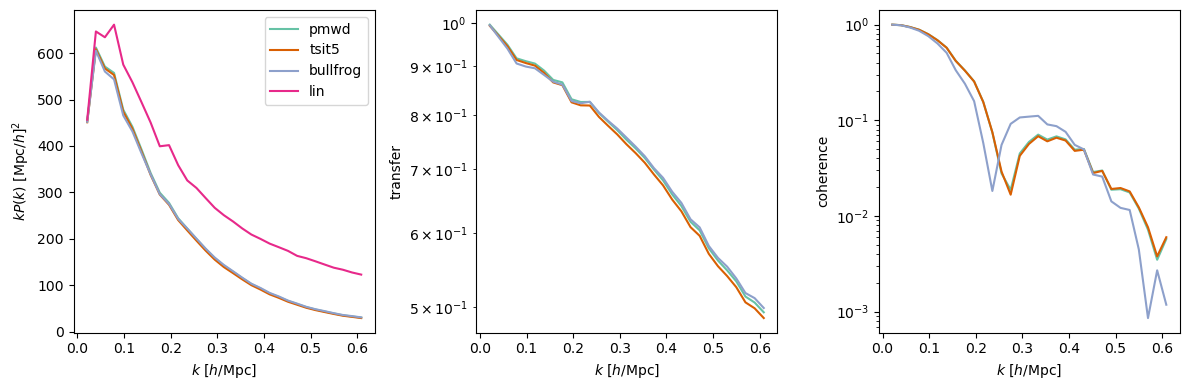

In [ ]:
def mse_fn(cosmo, ref, solver):
    mesh, _ = small_model(cosmo, model=model, solver=solver, pmeshk=pmeshk)
    mesh2 = model.powtranscoh(ref, mesh)
    ref2 = model.spectrum(ref)
    return jnp.mean((ref2[1] - mesh2[1])**2), mesh2

def mse_fn_pmwd(cosmo, ref):
    mesh = run_pmwd(cosmo, a_lpt=a_lpt, a_obs=a_obs, box_length=box_length, mesh_length=mesh_length, pmeshk=pmeshk)
    mesh2 = model.powtranscoh(ref, mesh)
    ref2 = model.spectrum(ref)
    return jnp.mean((ref2[1] - mesh2[1])**2), mesh2

cosmo = jnp.array([0.2607, 0.8102])
eps = 0.05
# cosmo += jnp.array([1., 0.])*eps
mesh, linmesh = small_model(cosmo, model, solver='bullfrog', pmeshk=pmeshk)
ref = linmesh
kpowlin = model.spectrum(linmesh)
# ks, ref = model.spectrum(mesh)

print("pmwd")
jax.config.update("jax_enable_x64", False)
ptc_pmwd = (lambda x: mse_fn_pmwd(x, ref=ref)[1])(cosmo)
print("tsit5")
ptc_t5 = (lambda x: mse_fn(x, ref=ref, solver='tsit5')[1])(cosmo)
print("bullfrog")
ptc_bf = (lambda x: mse_fn(x, ref=ref, solver='bullfrog')[1])(cosmo)

from montecosmo.plot import plot_pow, plot_powtranscoh, theme
theme()
plt.figure(figsize=(12, 4))
plot_powtranscoh(*ptc_pmwd, label='pmwd')
plot_powtranscoh(*ptc_t5, label='tsit5')
plot_powtranscoh(*ptc_bf, label='bullfrog')
plt.subplot(131)
plot_pow(*kpowlin, label='lin')
plt.legend()
plt.tight_layout()

In [49]:

print("pmwd")
jax.config.update("jax_enable_x64", False)
vg_pmwd = value_and_grad(lambda x: mse_fn_pmwd(x, ref=ref)[0])(cosmo)
print("tsit5")
vg_t5 = value_and_grad(lambda x: mse_fn(x, ref=ref, solver='tsit5')[0])(cosmo)
print("bullfrog")
vg_bf = value_and_grad(lambda x: mse_fn(x, ref=ref, solver='bullfrog')[0])(cosmo)
vg_pmwd, vg_t5, vg_bf, 


pmwd


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/p

tsit5
bullfrog


((Array(290228.3, dtype=float32), Array([nan,  0.], dtype=float32)),
 (Array(319886.1, dtype=float32), Array([100708.,      0.], dtype=float32)),
 (Array(349232.84, dtype=float32),
  Array([12290.118,     0.   ], dtype=float32)))

In [51]:
def value_and_grad2(f):
    eps = 1e-3
    eps1 = jnp.array([eps, 0.])
    eps2 = jnp.array([0., eps])
    def f2(x):
        x = jnp.asarray(x)
        fd1 = (f(x + eps1) - f(x - eps1)) / (2 * eps)
        fd2 = (f(x + eps2) - f(x - eps2)) / (2 * eps)
        return f(x), jnp.array([fd1, fd2])
    return f2

print("pmwd")
jax.config.update("jax_enable_x64", False)
vg_pmwd = value_and_grad2(lambda x: mse_fn_pmwd(x, ref=ref)[0])(cosmo)
print("tsit5")
vg_t5 = value_and_grad2(lambda x: mse_fn(x, ref=ref, solver='tsit5')[0])(cosmo)
print("bullfrog")
vg_bf = value_and_grad2(lambda x: mse_fn(x, ref=ref, solver='bullfrog')[0])(cosmo)
vg_pmwd, vg_t5, vg_bf, 

pmwd


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/p

tsit5
bullfrog


((Array(290228.44, dtype=float32),
  Array([17187.498,   750.   ], dtype=float32)),
 (Array(319891.5, dtype=float32),
  Array([104796.87 ,   1140.625], dtype=float32)),
 (Array(349234.44, dtype=float32),
  Array([12031.249,  -828.125], dtype=float32)))

## Whole Model Convergence

Running for nbody_steps=2
fin deconv
Running for nbody_steps=4
fin deconv
Running for nbody_steps=6
fin deconv
Running for nbody_steps=8
fin deconv


<Figure size 1200x400 with 0 Axes>

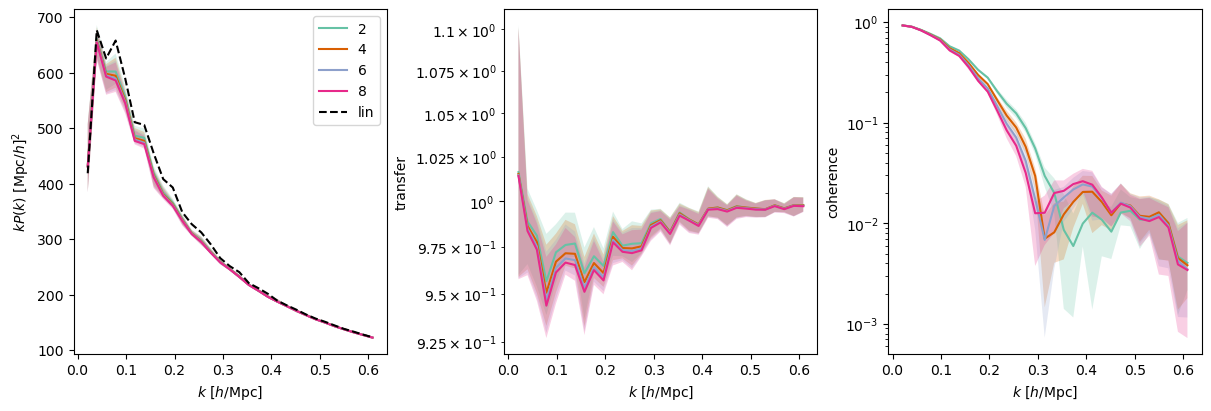

In [12]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
from montecosmo.nbody import a2g
from montecosmo.bricks import get_cosmology
theme()
model = FieldLevelModel(**default_config)

a_obss = [0.1, 0.5, 1.]
a_obs = .5
# n_stepss = [4, 16, 64, 256]
# n_stepss = [16, 32, 48, 64, 80]
# n_stepss = [32, 64, 96, 128]
# n_stepss = [8, 16, 24, 32]
n_stepss = [2, 4, 6, 8]
# kpow0s = []
# kptcs = []
# kptc_obss = []
log = False

prob = 0.95
plt.figure(1, figsize=(12, 4), layout='constrained')
plt.figure(2, figsize=(12, 4), layout='constrained')
# for i_a, a_obs in enumerate(a_obss):
for i_a, n_steps in enumerate(n_stepss):
    # print(f"Running for a_obs={a_obs}")
    print(f"Running for nbody_steps={n_steps}")

    model.a_obs = a_obs
    model.mesh_shape = 3 * (128,)
    model.box_shape = 5 * np.array(model.mesh_shape)
    model.evolution = 'nbody'
    model.lpt_order = 1
    model.nbody_steps = n_steps

    model.loc_fid['b1'] = 0.
    truth = {'Omega_m': 0.3111, 
            'sigma8': 0.8102, 
            'b1': 0.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    delta_obs = truth['obs'] - 1
    kaiser_post = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, base=True)))(jr.split(jr.key(42), 16))

    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kpow0 = model.spectrum(mesh0)
    # kpow0s.append(kpow0)

    kptc = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x['init_mesh'])))(kaiser_post)
    # kptcs.append(kptc)

    # kptc_obs = model.powtranscoh(mesh0, delta_obs)
    # # kptc_obss.append(kptc_obs)

    plt.figure(1)
    plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), log=log, label=f'{n_steps}')
    plot_powtranscoh(*kptc, fill=prob, log=log)

    plt.subplot(131)
    if i_a == len(n_stepss) - 1:
        plot_pow(*kpow0, 'k--', log=log, label='lin')
        # plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
        # plt.subplot(133)
        # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', log=log, label='obs')
    plt.subplot(131)
    plt.legend()


    # plt.figure(2)
    # plot_powtranscoh(*kptc_obs, log=log, label=f'{n_steps}')

    # plt.subplot(131)
    # if i_a == len(n_stepss) - 1:
    #     plot_pow(*kpow0, 'k--', log=log, label='lin')
    # plt.legend()

save_dir = './figs/'
title = f"m{model.mesh_shape[0]}_b{model.box_shape[0]}_a{a_obs}_e{model.evolution}"
title = "deconv2_" + title
# plt.figure(1)
# plt.savefig(save_dir+'kaipost_nsteps_'+title+'.svg', bbox_inches='tight')
# plt.figure(2)
# plt.savefig(save_dir+'obs_nsteps_'+title+'.svg', bbox_inches='tight')

## Lightcone

### Mesh to physical

In [ ]:
# from scipy.spatial.transform import Rotation
from jax.scipy.spatial.transform import Rotation
model = FieldLevelModel(**default_config | {'mesh_shape': 3*(128,), 'cell_length': 5., 
                                            # 'box_center': (500,500,500), 
                                            # 'box_center': (200,100,0), 
                                            'box_center': (200,100,50), 
                                            'box_rotvec': (0.,0.,1.),
                                            # 'box_center': (0,0,0), 
                                            'curved_sky': False,
                                             } )
def cell2phys_pos(pos, box_center, box_rot, box_shape, mesh_shape):
    pos *= (box_shape / mesh_shape)
    pos -= box_shape / 2
    pos = box_rot.apply(pos)
    pos += box_center
    return pos

def phys2cell_pos(pos, box_center, box_rot, box_shape, mesh_shape):
    pos -= box_center
    pos = box_rot.apply(pos, inverse=True)
    pos += box_shape / 2
    pos /= (box_shape / mesh_shape)
    return pos

def cell2phys_vel(vel, box_rot, box_shape, mesh_shape):
    vel *= (box_shape / mesh_shape)
    vel = box_rot.apply(vel)
    return vel

def phys2cell_vel(vel, box_rot, box_shape, mesh_shape):
    vel = box_rot.apply(vel, inverse=True)
    vel /= (box_shape / mesh_shape)
    return vel

def scale_pos(pos, los, scale_par, scale_perp):
    pos_par = (pos * los).sum(-1, keepdims=True) * los
    pos_perp = pos - pos_par
    pos_par *= scale_par
    pos_perp *= scale_perp
    return pos_par + pos_perp


pos = jnp.indices(model.mesh_shape, dtype=float).reshape(3,-1).T
mesh2phys = partial(cell2phys_pos, box_center=model.box_center, box_rot=model.box_rot, box_shape=model.box_shape, mesh_shape=model.mesh_shape)
phys2mesh = partial(phys2cell_pos, box_center=model.box_center, box_rot=model.box_rot, box_shape=model.box_shape, mesh_shape=model.mesh_shape)
# pos_phys = vmap(mesh2phys)(pos[None])
pos_phys = jit(mesh2phys)(pos)
pos_mesh = jit(phys2mesh)(pos_phys)


# def mesh2phys(ppos, box_center, box_rot, box_shape, mesh_shape):

pos_phys.min(0), pos_phys.max(0), pos_phys.mean(0), pos_phys.std(0), (model.box_center - .5 * model.box_shape)
((pos - pos_mesh)**2).mean()

Array(6.01040626e-30, dtype=float64)

### Radius bins

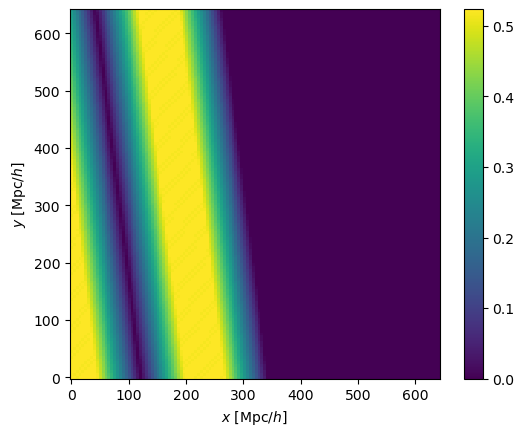

In [ ]:
from montecosmo.plot import plot_mesh, plot_powtranscoh
from montecosmo.utils import safe_div
model = FieldLevelModel(**default_config | {'mesh_shape': 3*(128,), 'cell_length': 5., 
                                            # 'box_center': (500,500,500), 
                                            # 'box_center': (200,100,0), 
                                            'box_center': (200,100,50), 
                                            'box_rotvec': np.array([0,0,1,])/3**.5*3* np.pi/16,
                                            # 'box_center': (0,0,0), 
                                            'curved_sky': False,
                                             } )
sli = 128


def radius_mesh(box_center, box_rot, box_shape, mesh_shape, curved_sky=True):
    """
    Return distances from center of the mesh cells.
    """
    rx = np.arange(mesh_shape[0]) + .5
    ry = np.arange(mesh_shape[1]) + .5
    rz = np.arange(mesh_shape[2]) + .5

    rx = rx.reshape([-1, 1, 1])
    ry = ry.reshape([1, -1, 1])
    rz = rz.reshape([1, 1, -1])
    rvec = rx, ry, rz

    box_center = box_rot.apply(box_center, inverse=True)
    if curved_sky:
        # Use that ||Rx + c|| = ||x + R^T c||
        rvec = [r * b / m - b / 2 + c for r, m, b, c in zip(rvec, mesh_shape, box_shape, box_center)]
        rmesh = sum(ri**2 for ri in rvec)**0.5
    else:
        # Use that l^T (Rx + c) = (R^T l)^T (x + R^T c)
        # Here l = c / ||c|| so R^T l = R^T c / ||R^T c|| 
        los = safe_div(box_center, np.linalg.norm(box_center))
        rvec = [(r * b / m - b / 2 + c) * l for r, m, b, c, l in zip(rvec, mesh_shape, box_shape, box_center, los)]
        rmesh = np.abs(sum(ri for ri in rvec))
    return rmesh

def radius_pos(pos, box_center, box_rot, box_shape, mesh_shape, curved_sky=True):
    """
    Return distances from center of the positions.
    """
    pos = mesh2phys(pos, box_center, box_rot, box_shape, mesh_shape)
    if curved_sky:
        rs = jnp.linalg.norm(pos, axis=-1)
    else:
        los = safe_div(box_center, np.linalg.norm(box_center))
        rs = (pos * los).sum(-1)
    return rs
    
# def los_pos(pos, box_center, box_rot, box_shape, mesh_shape, curved_sky=True):
#     """
#     Return line-of-sight(s) of the positions.
#     """
#     if curved_sky:
#         pos = mesh2phys(pos, box_center, box_rot, box_shape, mesh_shape)
#         los = safe_div(pos, jnp.linalg.norm(pos, axis=-1, keepdims=True))
#     else:
#         los = safe_div(box_center, np.linalg.norm(box_center))
#     return los


from montecosmo.bricks import Planck18
from montecosmo.nbody import a2chi, chi2a, a2g, g2a
cosmo = Planck18()

def scalefactors_and_redges(cosmo, rmin, rmax, n_shells):
    """
    Return radius shell edges and corresponding scale factors.
    """
    gmin, gmax = a2g(cosmo, chi2a(cosmo, rmax)), a2g(cosmo, chi2a(cosmo, rmin))
    gs = np.linspace(gmin, gmax, n_shells+1)
    redges = a2chi(cosmo, g2a(cosmo, gs)) # decreasing distance
    a = g2a(cosmo, (gs[:-1] + gs[1:]) / 2)
    return a, redges

rmesh = radius_mesh(model.box_center, model.box_rot, model.box_shape, model.mesh_shape, model.curved_sky)
a2sim, redges = scalefactors_and_redges(cosmo, rmesh.min(), rmesh.max(), 10)

i_bin = 7
rmask = (redges[1:][i_bin] < rmesh) & (rmesh <= redges[:-1][i_bin])

plot_mesh(rmask, model.box_shape, sli)
plt.colorbar()

In [ ]:
from montecosmo.nbody import lpt
from montecosmo.bricks import Planck18, lin_power_mesh
from jaxpm.painting import cic_paint, cic_read

def evolve_bins(model, n_edges):
    cosmology = Planck18()
    pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
    linmesh = jr.normal(jr.key(0), model.mesh_shape)
    linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
    init = {'init_mesh':linmesh}

    gxy_mesh = jnp.zeros(model.mesh_shape)
    rmesh = radius_mesh(model.mesh_shape, model.box_shape, model.center)
    redges, a2sims = scalefactors_and_redges(cosmo, n_edges)

    pos = jnp.indices(model.mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}  # HACK: temporary fix

    def lpt_step(gxy_mesh, xs):
        i_bin, a = xs
        dpos, vel = lpt(cosmology, **init, pos=pos, a=a, order=model.lpt_order)
        mesh = cic_paint(jnp.zeros(model.mesh_shape), pos + dpos)

        rmask = (redges[1:][i_bin] < rmesh) & (rmesh <= redges[:-1][i_bin])
        gxy_mesh += mesh * rmask
        return gxy_mesh, None
    
    xs = jnp.arange(len(a2sims)), a2sims
    gxy_mesh, _ = lax.scan(lpt_step, gxy_mesh, xs)

    linmesh = jnp.fft.irfftn(linmesh)
    return linmesh, gxy_mesh

### LPT displacement

In [8]:
def evolve_disp(model, lc=True, lc2=True):
    cosmology = Planck18()
    pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
    linmesh = jr.normal(jr.key(0), model.mesh_shape)
    linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
    init = {'init_mesh':linmesh}

    pos = jnp.indices(model.mesh_shape).reshape(3,-1).T
    rad = radius_pos(pos, model.mesh_shape, model.box_shape, model.center)
    scalefac = chi2a(cosmo, rad)[:,None]
    if not lc:
        scalefac = scalefac.mean()
        print(f"constant scale factor: {scalefac}")

    cosmology._workspace = {}  # HACK: temporary fix
    dpos, vel = lpt(cosmology, **init, pos=pos, a=scalefac, order=model.lpt_order, lc2=lc2, model=model)

    gxy_mesh = cic_paint(jnp.zeros(model.mesh_shape), pos + dpos)
    linmesh = jnp.fft.irfftn(linmesh)
    return linmesh, gxy_mesh

### LPT displacement (fixed point method)

In [9]:
def evolve_disp(model, lc=True, n_fixed_points=1):
    cosmology = Planck18()
    pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
    linmesh = jr.normal(jr.key(0), model.mesh_shape)
    linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
    init = {'init_mesh':linmesh}

    init_pos = jnp.indices(model.mesh_shape).reshape(3,-1).T
    pos = init_pos

    if not lc:
        rad = radius_pos(pos, model.mesh_shape, model.box_shape, model.center)
        scalefac = chi2a(cosmo, rad)[:,None]
        scalefac = scalefac.mean()
        print(f"constant scale factor: {scalefac}")
        cosmology._workspace = {}  # HACK: temporary fix
        dpos, vel = lpt(cosmology, **init, pos=init_pos, a=scalefac, order=model.lpt_order)
        gxy_mesh = cic_paint(jnp.zeros(model.mesh_shape), init_pos + dpos)
        linmesh = jnp.fft.irfftn(linmesh)
        return linmesh, gxy_mesh

    for i in range(n_fixed_points):
        rad = radius_pos(pos, model.mesh_shape, model.box_shape, model.center)
        scalefac = chi2a(cosmo, rad)[:,None]

        cosmology._workspace = {}  # HACK: temporary fix
        dpos, vel = lpt(cosmology, **init, pos=init_pos, a=scalefac, order=model.lpt_order)
        pos = init_pos + dpos

    gxy_mesh = cic_paint(jnp.zeros(model.mesh_shape), pos)
    linmesh = jnp.fft.irfftn(linmesh)
    return linmesh, gxy_mesh

### Comparison

In [ ]:
linmesh, gxy_mesh0 = evolve_disp(model, lc=False, lc2=False)
linmesh, gxy_mesh_disp = evolve_disp(model, lc=True, lc2=False)
linmesh, gxy_mesh_disp2 = evolve_disp(model, lc=True, lc2=True)
linmesh, gxy_mesh_bins = evolve_bins(model, n_edges=100)

In [12]:
linmesh, gxy_mesh0 = evolve_disp(model, lc=False)
linmesh, gxy_mesh_disp = evolve_disp(model, lc=True, n_fixed_points=1)
linmesh, gxy_mesh_disp2 = evolve_disp(model, lc=True, n_fixed_points=2)
linmesh, gxy_mesh_bins = evolve_bins(model, n_edges=100)

constant scale factor: 0.7453132213174406


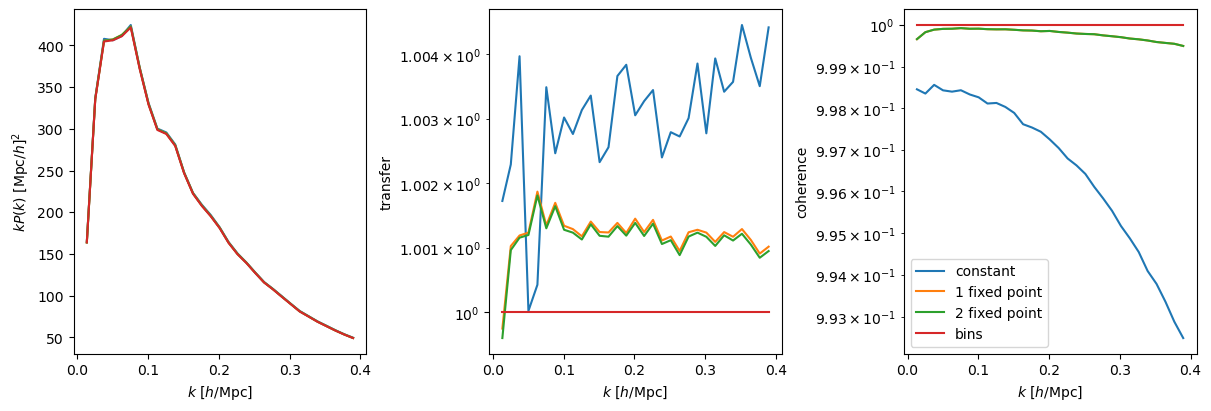

In [13]:
# kptc0 = model.powtranscoh(gxy_mesh0, gxy_mesh0)
# kptc_disp = model.powtranscoh(gxy_mesh0, gxy_mesh_disp)
# kptc_disp2 = model.powtranscoh(gxy_mesh0, gxy_mesh_disp2)
# kptc_bins = model.powtranscoh(gxy_mesh0, gxy_mesh_bins)

kptc0 = model.powtranscoh(gxy_mesh_bins, gxy_mesh0)
kptc_disp = model.powtranscoh(gxy_mesh_bins, gxy_mesh_disp)
kptc_disp2 = model.powtranscoh(gxy_mesh_bins, gxy_mesh_disp2)
kptc_bins = model.powtranscoh(gxy_mesh_bins, gxy_mesh_bins)

plt.figure(figsize=(12, 4), layout='constrained')
plot_powtranscoh(*kptc0, label='constant')
plot_powtranscoh(*kptc_disp, label='1 fixed point')
plot_powtranscoh(*kptc_disp2, label='2 fixed point')
plot_powtranscoh(*kptc_bins, label='bins')
plt.legend()
# plt.savefig('lightcones.pdf', bbox_inches='tight')

## RSD
3 RSD models: Kaiser, delta, AP

In [41]:
truth = {'Omega_m': 0.3, 
        'sigma8': 0.8, 
        'b1': 0.,
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

conf = default_config | {'box_shape': 3*(5280.,), 
                        'mesh_shape': 3* (256,),
                        'a_obs': 1.,
                        'evolution': 'kaiser',
                        'curved_sky': False, 
                        'box_center': (0,0,1),
                        'gxy_density': 1e6,}

model = FieldLevelModel(**conf)
truth_kaiser = model.predict(samples=truth, hide_base=False, hide_samp=True, hide_det=False, frombase=True)
mesh0 = jnp.fft.irfftn(truth_kaiser['init_mesh'])

model = FieldLevelModel(**conf | {'evolution': 'lpt'})
truth_lpt = model.predict(samples=truth, hide_base=False, hide_samp=True, hide_det=False, frombase=True)

vel: (Array(4.36011725, dtype=float64), Array(1.89351333, dtype=float64), Array(0.02050162, dtype=float64), Array(19.02897683, dtype=float64))


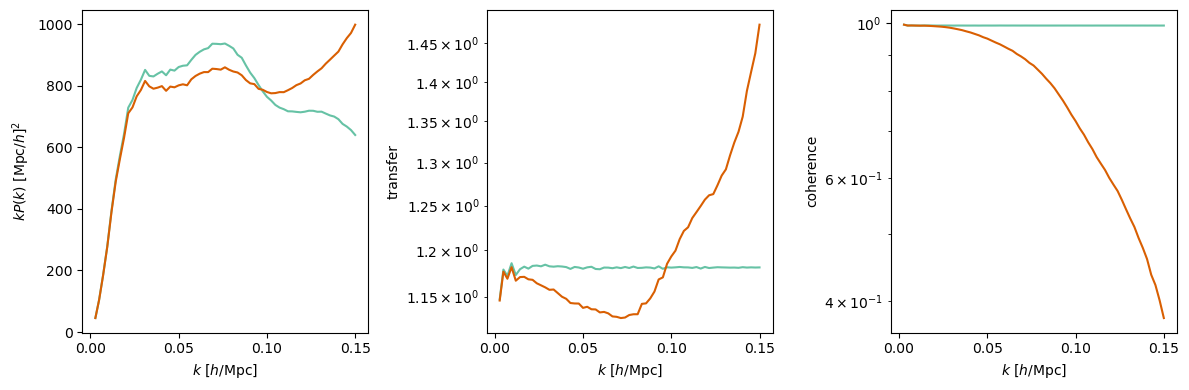

In [42]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme
theme() 

# Compute the power spectrum, transfer, and coherence
kptc_kaiser = model.powtranscoh(mesh0, truth_kaiser['gxy_mesh'])
kptc_lpt = model.powtranscoh(mesh0, truth_lpt['gxy_mesh'])

# Plot the results
plt.figure(figsize=(12, 4))
plot_powtranscoh(*kptc_kaiser)
plot_powtranscoh(*kptc_lpt)

# klim = 0.5
# plt.subplot(131)
# plt.xlim(0, klim)
# plt.subplot(132)
# plt.xlim(0, klim)
# plt.subplot(133)
# plt.xlim(0, klim)

plt.tight_layout()
plt.show()

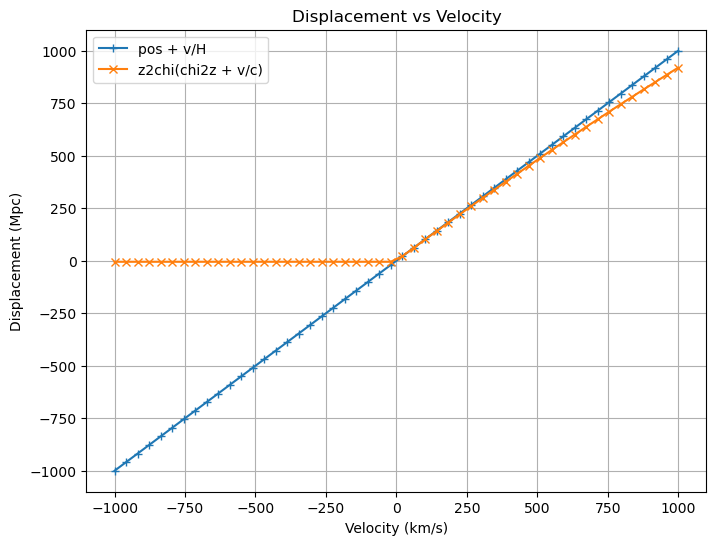

In [ ]:
from montecosmo.bricks import Planck18
from montecosmo.nbody import a2chi, chi2a
import jax_cosmo as jc
from jax_cosmo import background, constants
import numpy as np

# Define constants
cosmo = Planck18()

# Define line-of-sight velocities
vlim = 1000
velocities = np.linspace(-vlim, vlim, 50)  # 10 values from 0 to 100 km/s

# Define a sample position in Mpc
pos = 9400.0 
pos = 1000.0 
pos = 5.0 
# pos = 0.0 

# Compute RSD displacements using both methods
displacements_formula = []
displacements_chi2z = []

for v in velocities:
    # Method 1: pos = pos + v / H
    a = chi2a(cosmo, pos)
    pos_formula = pos + v / background.Esqr(cosmo, a)**.5
    displacements_formula.append(pos_formula - pos)

    # Method 2: pos = z2chi(chi2z(pos) + v / c)
    a = (1 / chi2a(cosmo, pos) + v / constants.rh)**-1
    pos_chi2z = a2chi(cosmo, a)  # Convert back to position
    displacements_chi2z.append(pos_chi2z - pos)

# Plot the displacements with respect to velocity
plt.figure(figsize=(8, 6))
plt.plot(velocities, displacements_formula, label="pos + v/H", marker='+')
plt.plot(velocities, displacements_chi2z, label="z2chi(chi2z + v/c)", marker='x')

# Add labels, legend, and title
plt.xlabel("Velocity (km/s)")
plt.ylabel("Displacement (Mpc)")
plt.title("Displacement vs Velocity")
plt.legend()
plt.grid(True)
plt.show()

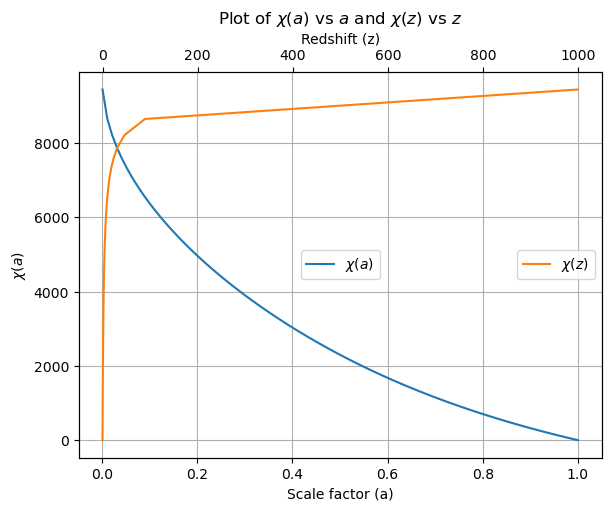

In [65]:
# Compute chi(a) for a range of scale factors
a_values = jnp.linspace(0.001, 1, 100)  # Avoid a=0 to prevent division by zero
chi_values = a2chi(cosmo, a_values)
z_values = 1 / a_values - 1  # Compute redshift values

# Plot the results
fig, ax1 = plt.subplots(figsize=(6, 5), layout='constrained')

# Plot chi(a) with respect to scale factor (a)
ax1.plot(a_values, chi_values, label=r"$\chi(a)$", color="C0")
ax1.set_xlabel("Scale factor (a)")
ax1.set_ylabel(r"$\chi(a)$")
ax1.grid(True)
ax1.legend(loc="center")

# Add a second x-axis for redshift (z)
ax2 = ax1.twiny()
ax2.plot(z_values, chi_values, label=r"$\chi(z)$", color="C1")
ax2.set_xlabel("Redshift (z)")
ax2.legend(loc="center right")

plt.title(r"Plot of $\chi(a)$ vs $a$ and $\chi(z)$ vs $z$")
plt.show()


## Mask

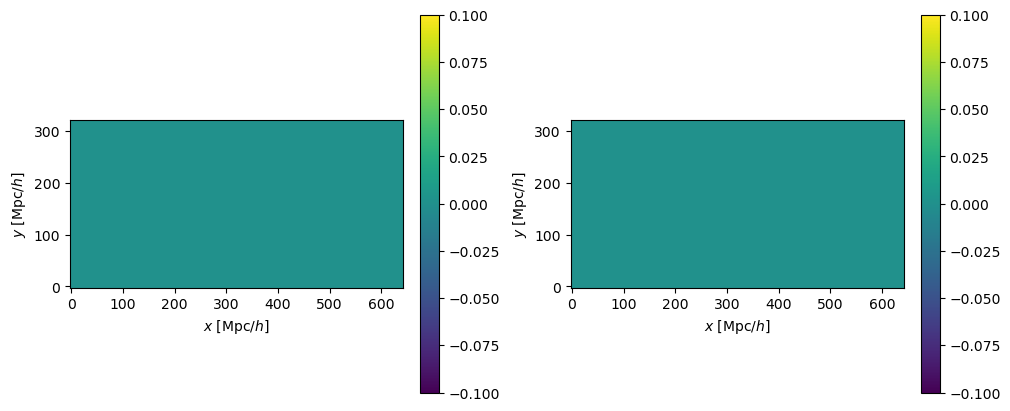

In [ ]:
from montecosmo.plot import plot_mesh, plot_powtranscoh
from montecosmo.utils import safe_div
model = FieldLevelModel(**default_config | {'mesh_shape': (128,64,32), 'cell_length': 5, 
                                            # 'box_center': (500,500,500), 
                                            # 'box_center': (200,100,0), 
                                            'box_center': (200,100,50), 
                                            # 'box_center': (0,0,0), 
                                            'curved_sky': False} )
sli = 128


def simple_mask(mesh_shape, frac=.5, ord:float=np.inf):
    """
    Return a simple mask obtained by cropping a fraction of the mesh as an ord-norm ball.
    """
    ord = float(ord)
    rx = jnp.abs((np.arange(mesh_shape[0]) + .5) * 2 / mesh_shape[0] - 1)
    ry = jnp.abs((np.arange(mesh_shape[1]) + .5) * 2 / mesh_shape[1] - 1)
    rz = jnp.abs((np.arange(mesh_shape[2]) + .5) * 2 / mesh_shape[2] - 1)

    rx = rx.reshape([-1, 1, 1])
    ry = ry.reshape([1, -1, 1])
    rz = rz.reshape([1, 1, -1])
    rvec = rx, ry, rz

    if ord == np.inf:
        rmesh = np.maximum(np.maximum(rvec[0], rvec[1]), rvec[2])
    elif ord == -np.inf:
        rmesh = np.minimum(np.minimum(rvec[0], rvec[1]), rvec[2])
    else:
        rmesh = sum(ri**ord for ri in rvec)**(1/ord)

    mask = rmesh < frac**(1/3)
    return mask


mask = simple_mask(model.mesh_shape, 0.5, ord=jnp.inf)

plt.figure(figsize=(10, 4), layout='constrained')
plt.subplot(121)
plot_mesh(mask, model.box_shape, sli)
plt.colorbar()

mesh = jr.normal(jr.key(0), model.mesh_shape)
mesh = mesh[mask]

def mesh2masked(mesh, mask):
    return mesh[mask]

def masked2mesh(masked, mask):
    mesh = jnp.zeros(mask.shape)
    mesh = mesh.at[mask].set(masked)
    return mesh

mesh = masked2mesh(mesh, mask)

plt.subplot(122)
plot_mesh(mesh, model.box_shape, sli)
plt.colorbar()

In [77]:
aa = jnp.abs(np.arange(5)[None] - 3)
bb = jnp.abs(np.arange(5)[:,None] - 3)
cc = np.arange(5)[:,None,None]
arrays = [aa, bb, cc]
result = np.maximum(np.maximum(aa, bb), cc)
result

array([[[3, 3, 3, 3, 3],
        [3, 2, 2, 2, 2],
        [3, 2, 1, 1, 1],
        [3, 2, 1, 0, 1],
        [3, 2, 1, 1, 1]],

       [[3, 3, 3, 3, 3],
        [3, 2, 2, 2, 2],
        [3, 2, 1, 1, 1],
        [3, 2, 1, 1, 1],
        [3, 2, 1, 1, 1]],

       [[3, 3, 3, 3, 3],
        [3, 2, 2, 2, 2],
        [3, 2, 2, 2, 2],
        [3, 2, 2, 2, 2],
        [3, 2, 2, 2, 2]],

       [[3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3]],

       [[4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4]]])

## AP

In [2]:
from scipy.spatial.transform import Rotation

def radius_mesh(box_center, box_rot:Rotation, box_shape, mesh_shape):
    """
    Return physical distances of the mesh cells.
    """
    # Only Nx*Ny*Nz memory instead of naive Nx*Ny*Nz*3 obtained from mesh of positions 
    rx = np.arange(mesh_shape[0]).reshape([-1, 1, 1])
    ry = np.arange(mesh_shape[1]).reshape([1, -1, 1])
    rz = np.arange(mesh_shape[2]).reshape([1, 1, -1])
    rvec = rx, ry, rz

    box_center = box_rot.apply(box_center, inverse=True)
    # Use that ||Rx + c|| = ||x + R^T c|| to avoid computing Rx
    rvec = [r * b / m - b / 2 + c for r, m, b, c in zip(rvec, mesh_shape, box_shape, box_center)]
    rmesh = sum(ri**2 for ri in rvec)**.5
    return rmesh


def distr_radial(mesh, rmesh, redges:int|float|list, aggr_fn=None):
    assert np.shape(mesh) == np.shape(rmesh), "value mesh and radius mesh must have same shape."

    if isinstance(redges, (int, float)):
        rmin, rmax = rmesh.min(), rmesh.max()
        if isinstance(redges, int):
            dr = (rmax - rmin) / redges # final number of bins will be kedges-1
            redges = np.linspace(rmin, rmax, redges, endpoint=False)
        elif isinstance(redges, float):
            dr = redges
            redges = np.arange(rmin, rmax, dr)
        redges += dr / 2 # from rmin+dr/2 to rmax-dr/2

    dig = np.digitize(rmesh.reshape(-1), redges)
    rcount = np.bincount(dig)
    rcount = rcount[1:-1]

    ravg = np.bincount(dig, weights=rmesh.reshape(-1))
    ravg = ravg[1:-1] / rcount

    if aggr_fn is None: # aggregate by averaging 
        naggr = np.bincount(dig, weights=mesh.reshape(-1))
        naggr = naggr[1:-1] / rcount
    else:
        naggr = []
        for low, high in zip(redges[:-1], redges[1:]):
            rmask = (low < rmesh) & (rmesh <= high)
            vals = mesh[rmask]
            naggr.append(aggr_fn(vals))
        naggr = np.array(naggr)

        # naggr = jnp.empty((len(redges)-1, 2))
        # for i_bin, (low, high) in enumerate(zip(redges[:-1], redges[1:])):
        #     rmask = (low < rmesh) & (rmesh <= high)
        #     vals = mesh[rmask]
        #     # naggr[i_bin] = credint(vals)
        #     # naggr = naggr.at[i_bin].set(credint(vals))
    return ravg, naggr


def distr_angular():
    pass



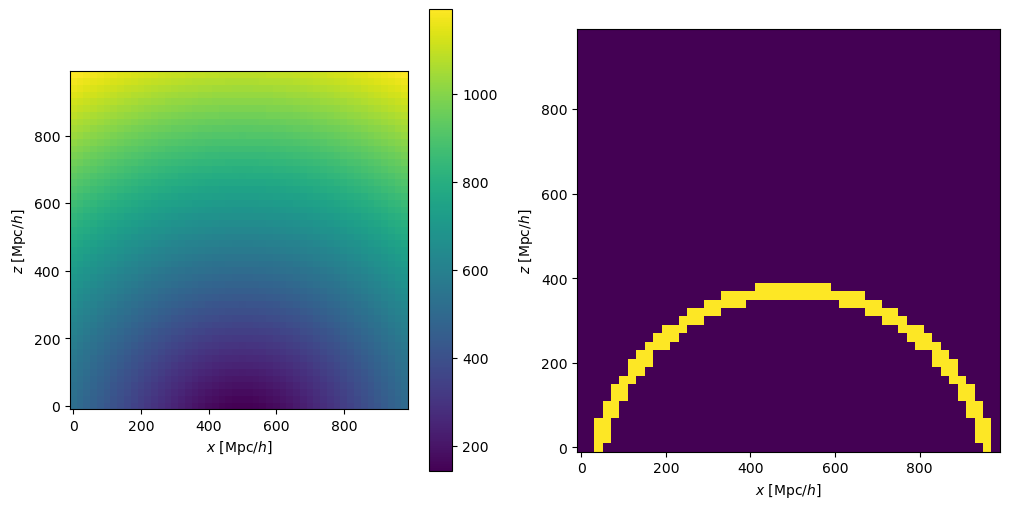

In [14]:
from montecosmo.bricks import regular_pos, phys2cell_pos, cell2phys_pos, Planck18, simple_window, masked2mesh, scale_pos
from montecosmo.bdec import credint
from montecosmo.nbody import paint, read, a2chi, chi2a
from montecosmo.utils import safe_div

# box_center = np.array((0,0,0))
box_center = np.array((0,0,600.))
box_rot = Rotation.from_rotvec((0,0,0))
box_shape = np.array((1000,1000,1000))
mesh_shape = np.array(3*(50,))
rmesh = radius_mesh(box_center, box_rot, box_shape, mesh_shape)
los = safe_div(box_center, np.linalg.norm(box_center))

cell_length = box_shape / mesh_shape

def get_redges(redges):
    if isinstance(redges, (type(None), int, float)):
        rmin, rmax = rmesh.min(), rmesh.max()
        if redges is None:
            dr = 3**.5 * cell_length[0] 
            redges = np.arange(rmin, rmax, dr)
        elif isinstance(redges, int):
            dr = (rmax - rmin) / redges # final number of bins will be kedges-1
            redges = np.linspace(rmin, rmax, redges, endpoint=False)
        elif isinstance(redges, float):
            dr = redges
            redges = np.arange(rmin, rmax, dr)
        redges += dr / 2 # from rmin+dr/2 to rmax-dr/2
    return redges

redges = get_redges(None)

from montecosmo.plot import plot_mesh
ax = -2
ind = np.array([20])
# ind = 0.05

plt.figure(figsize=(12,6))
plt.subplot(121)
plot_mesh(rmesh, box_shape, ind, ax)
plt.colorbar()

plt.subplot(122)
i_m = 10
low, high = redges[:-1][i_m], redges[1:][i_m]
mask = (low < rmesh) & (rmesh <= high)
plot_mesh(mask, box_shape, ind, ax)

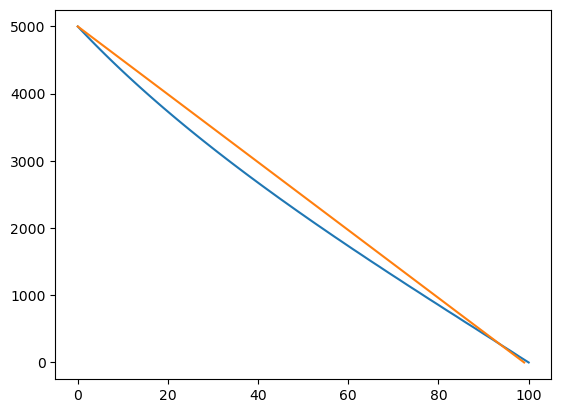

In [ ]:
from montecosmo.nbody import a2g, g2a

def redges_and_scalefactors(cosmo, rmin, rmax, n_shells):
    """
    Return radius shell edges and their effective scale factors.
    Shell edges are linearly spaced in growth factor.
    """
    gmin, gmax = a2g(cosmo, chi2a(cosmo, rmax)), a2g(cosmo, chi2a(cosmo, rmin))
    gs = np.linspace(gmin, gmax, n_shells+1)
    redges = a2chi(cosmo, g2a(cosmo, gs)) # decreasing distance
    a = g2a(cosmo, (gs[:-1] + gs[1:]) / 2)
    return redges, a

cosmo_fid = Planck18()
rmin, rmax = 0, 5000
redgesg, ag = redges_and_scalefactors(cosmo_fid, rmin, rmax, 100)
plt.plot(redgesg)
plt.plot(np.linspace(rmin, rmax, 100)[::-1])

In [ ]:
from montecosmo.bricks import regular_pos, phys2cell_pos, cell2phys_pos, Planck18, simple_window, masked2mesh, scale_pos
from montecosmo.bdec import credint
from montecosmo.nbody import paint, read, a2chi, chi2a
from montecosmo.utils import safe_div


# box_center = np.array((0,0,0))
box_center = np.array((0,0,600.))
box_rot = Rotation.from_rotvec((0,0,0))
box_shape = np.array((1000,1000,1000))
mesh_shape = np.array(3*(50,))
rmesh = radius_mesh(box_center, box_rot, box_shape, mesh_shape)
los = safe_div(box_center, np.linalg.norm(box_center))



pos0 = regular_pos(mesh_shape, mesh_shape)
mesh0 = paint(pos0, tuple(mesh_shape))
# mesh0 = np.array(jr.normal(jr.key(0), mesh_shape))

wind_mesh = simple_window(mesh_shape, padding=0.2)
mask = wind_mesh > 0.
redges = 30
ravg, navg0 = distr_radial(mesh0[mask], rmesh[mask], redges)
# ravg, nmed0 = distr_radial(mesh0[rmask], rmesh[rmask], redges, jnp.median)
ravg, ncredint0 = distr_radial(mesh0[mask], rmesh[mask], redges, credint)

2025-06-15 11:25:00.745037: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
pos = cell2phys_pos(pos0, box_center, box_rot, box_shape, mesh_shape)

cosmo = Planck18(Omega_c=0.3)
cosmo_fid = Planck18()
def alpha_fn(rpos):
    rpos_new = a2chi(cosmo_fid, chi2a(cosmo, rpos))
    return safe_div(rpos_new, rpos)


# def alpha_fn(rpos):
#     # return (rpos / 500)**0.01
#     return jnp.sin(rpos / 500)*0.1 + 1

def ap_fn(pos):
    rpos = jnp.linalg.norm(pos, axis=-1, keepdims=True)
    pos *= alpha_fn(rpos)
    return pos

def detjac_fn(pos):
    rpos = jnp.linalg.norm(pos)
    alpha = alpha_fn(rpos)
    d = jnp.shape(pos)[-1]
    detjac = alpha**(d - 1) * (alpha + rpos * grad(alpha_fn)(rpos))
    return detjac



# def ap_fn(pos):
#     rpos = jnp.abs((pos * los).sum(-1, keepdims=True))
#     alpha = alpha_fn(rpos)
#     pos = scale_pos(pos, los, alpha, 1)
#     return pos

# def detjac_fn(pos):
#     rpos = jnp.abs((pos * los).sum(-1))
#     alpha = alpha_fn(rpos)
#     detjac = (alpha + rpos * grad(alpha_fn)(rpos))
#     return detjac


from jax import jacrev
absdetjac = vmap(jacrev(ap_fn))(pos)
absdetjac = jnp.abs(jnp.linalg.det(absdetjac))

detjac = vmap(detjac_fn)(pos)
print("absdetjac:", absdetjac)
print("detjac:", detjac)
print(np.allclose(absdetjac, detjac))


# pos = .9 * pos
pos = ap_fn(pos)
pos = phys2cell_pos(pos, box_center, box_rot, box_shape, mesh_shape)


mesh1 = paint(pos, tuple(mesh_shape))
# mesh1 = mesh1 / mesh1[rmask].mean()
ravg, navg1 = distr_radial(mesh1[mask], rmesh[mask], redges)
ravg, ncredint1 = distr_radial(mesh1[mask], rmesh[mask], redges, credint)

# mesh = paint(pos, tuple(mesh_shape), 0.9**3)
mesh = paint(pos, tuple(mesh_shape), detjac)
ravg, navg = distr_radial(mesh[mask], rmesh[mask], redges)
ravg, ncredint = distr_radial(mesh[mask], rmesh[mask], redges, credint)



absdetjac: [1.02968814 1.02975431 1.02983143 ... 1.05199121 1.05235139 1.05270406]
detjac: [1.02968814 1.02975431 1.02983143 ... 1.05199121 1.05235139 1.05270406]
True


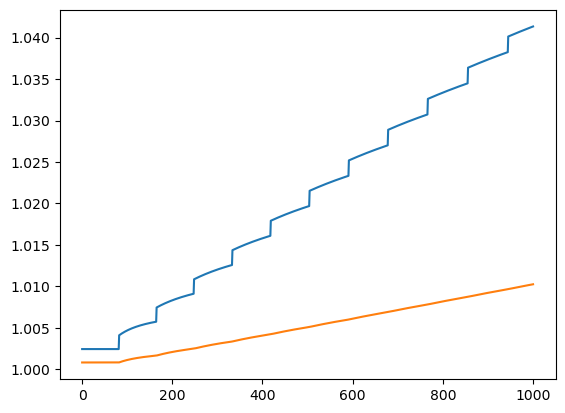

In [ ]:
cosmo = Planck18(Omega_c=0.3)
cosmo_fid = Planck18()
def alpha_fn(rpos):
    rpos_new = a2chi(cosmo_fid, chi2a(cosmo, rpos))
    return safe_div(rpos_new, rpos)

def ap_fn(pos):
    rpos = jnp.linalg.norm(pos, axis=-1, keepdims=True)
    pos *= alpha_fn(rpos)
    return pos

def detjac_fn(rpos):
    alpha = alpha_fn(rpos)
    detjac = alpha**2 * (alpha + rpos * grad(alpha_fn)(rpos))
    return detjac


rpos =  jnp.linspace(0.1, 1000, 1000)
plt.plot(rpos, vmap(detjac_fn)(rpos), label="absdetjac")
plt.plot(rpos, vmap((alpha_fn))(rpos), label="alpha")

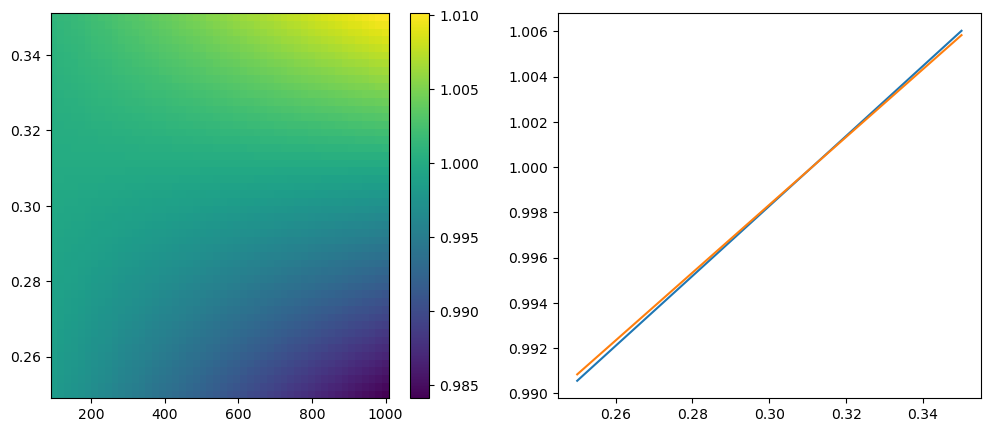

In [ ]:
def alpha_fn(x):
    rpos, Omega_m = x
    cosmo = Planck18(Omega_c=Omega_m - Planck18.keywords['Omega_b'])
    cosmo_fid = Planck18(Omega_c=0.3111 - Planck18.keywords['Omega_b'])
    rpos_new = a2chi(cosmo_fid, chi2a(cosmo, rpos))
    return safe_div(rpos_new, rpos)

from montecosmo.plot import plot_bivar
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_bivar(vmap((alpha_fn)), box=((100,1000), (0.25, 0.35)))
# plot_bivar(lambda x: vmap(grad(alpha_fn))(x)[:,0], box=((100,1000), (0.25, 0.35)))
plt.colorbar()

plt.subplot(122)
Oms = jnp.linspace(0.25, 0.35, 100)
plt.plot(Oms, vmap((lambda x: alpha_fn((600., x))))(Oms))
plt.plot(Oms, 0.15 * (Oms - 0.3111) + 1)

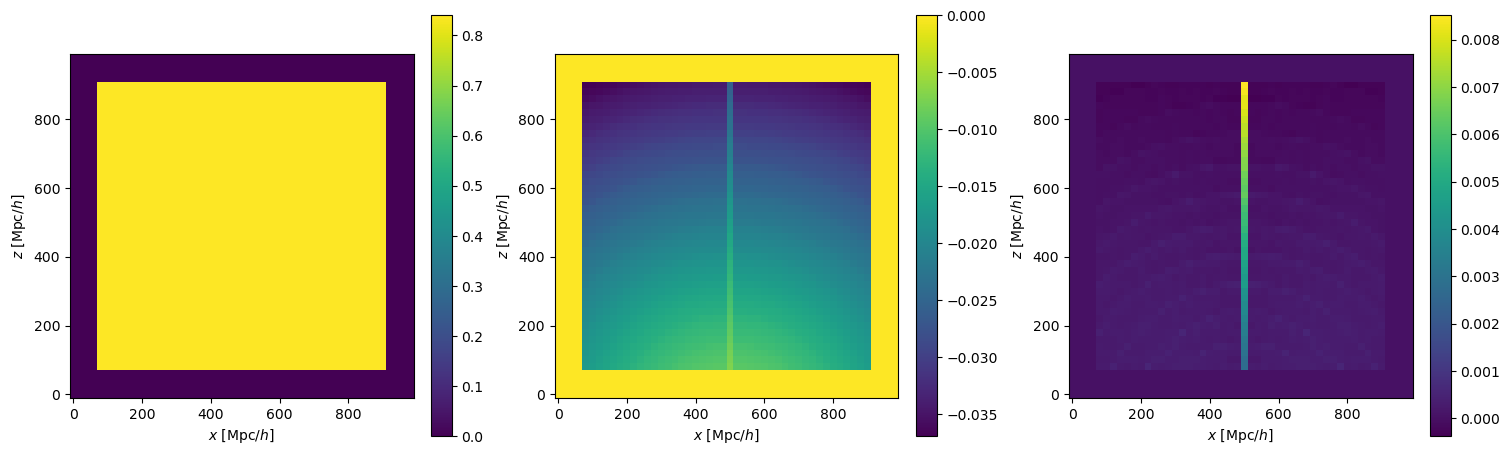

In [ ]:
from montecosmo.plot import plot_mesh
ax = -2
plt.figure(figsize=(15, 4.5), layout='constrained')
plt.subplot(131)
mm0 = masked2mesh(mesh0[mask], mask)
plot_mesh(mm0, box_shape, axis=ax)
plt.colorbar()

plt.subplot(132)
mm1 = masked2mesh(mesh1[mask], mask)
plot_mesh(mm1-mm0, box_shape, axis=ax)
plt.colorbar()

plt.subplot(133)
mm = masked2mesh(mesh[mask], mask)
plot_mesh(mm-mm0, box_shape, axis=ax)
plt.colorbar()

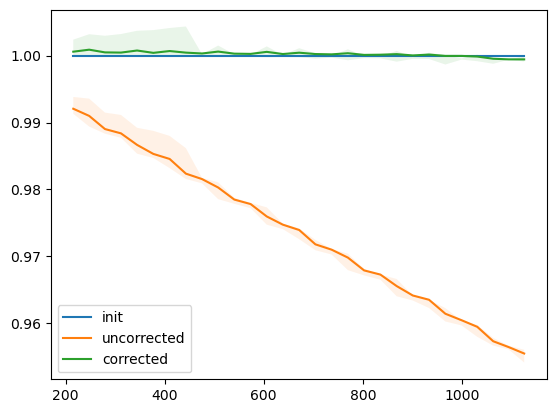

In [ ]:
plt.plot(ravg, navg0, label="init")
# plt.plot(ravg, nmed0)
plt.fill_between(ravg, *ncredint0.T, alpha=0.1)

plt.plot(ravg, navg1, label="uncorrected")
plt.fill_between(ravg, *ncredint1.T, alpha=0.1)

plt.plot(ravg, navg, label="corrected")
plt.fill_between(ravg, *ncredint.T, alpha=0.1)
plt.legend()

## Kernels

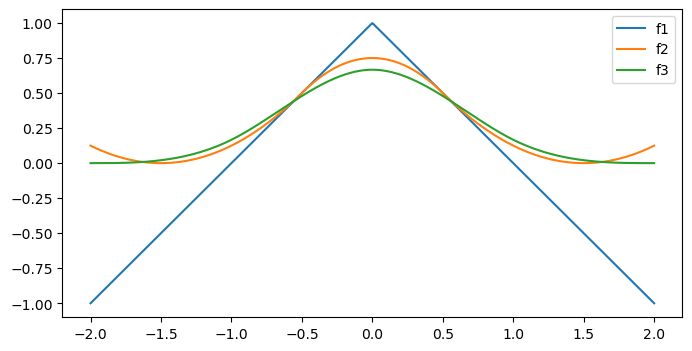

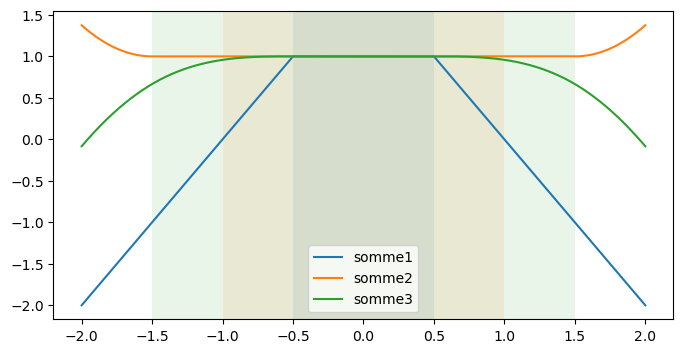

In [ ]:
from montecosmo.nbody import paint_kernels
f1, f2, f3 = lambda x: paint_kernels[2](jnp.abs(x)),  \
            lambda x: paint_kernels[3](jnp.abs(x)), \
            lambda x: paint_kernels[4](jnp.abs(x))
xs = jnp.linspace(-2, 2, 1000)
plt.figure(figsize=(8, 4))
plt.plot(xs, f1(xs), label="f1")
plt.plot(xs, f2(xs), label="f2")
plt.plot(xs, f3(xs), label="f3")
plt.legend()

plt.figure(figsize=(8, 4))
somme1 = lambda xshift: f1(xshift+.5) + f1(xshift-.5)
somme2 = lambda xshift: f2(xshift-1) + f2(xshift + 1) + f2(xshift) 
somme3 = lambda xshift: f3(xshift-1.5) + f3(xshift + 1.5) + f3(xshift+.5) + f3(xshift-.5) 
plt.plot(xs, somme1(xs), label="somme1")
plt.plot(xs, somme2(xs), label="somme2")
plt.plot(xs, somme3(xs), label="somme3")
plt.ylim(plt.ylim())
plt.fill_betweenx(plt.ylim(), -.5, .5, alpha=.1)
plt.fill_betweenx(plt.ylim(), -1, 1, alpha=.1)
plt.fill_betweenx(plt.ylim(), -1.5, 1.5, alpha=.1)
plt.legend()

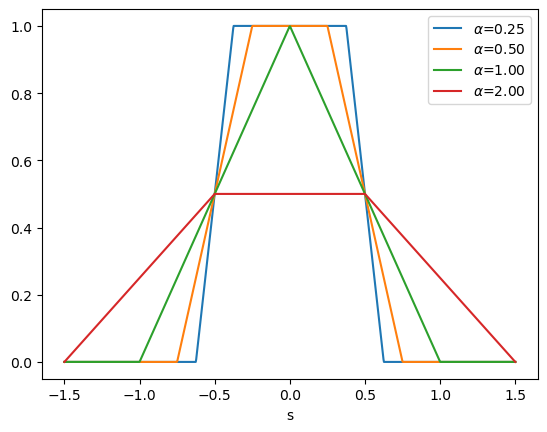

In [ ]:
def cic_alpha(s, alpha=1.):
    m = (1 + alpha) / 2
    d = jnp.abs(1 - alpha) / 2
    out = (s <= d) * jnp.minimum(1, alpha) + ((d < s) & (s <= m)) * (m - s)
    return out / alpha

lim = 1.5
xs = jnp.linspace(-lim, lim, 1000)
for alpha in 2**np.arange(-2, 2, 1.):
    plt.plot(xs, cic_alpha(jnp.abs(xs), alpha), label=f"$\\alpha$={alpha:.2f}")
plt.xlabel("s")
plt.legend()

In [ ]:
from montecosmo.bricks import lin_power_mesh, regular_pos, kaiser_model
from montecosmo.nbody import paint, read, deconv_paint, lpt, paint_kernels

model.ptcl_shape = np.array((350, 350, 350))
model.mesh_shape = np.array((350, 350, 350))

mesh = jr.normal(jr.key(0), model.mesh_shape)
pmesh = lin_power_mesh(model.cosmo_fid, model.mesh_shape, model.box_shape)
# mesh = jnp.fft.irfftn(jnp.fft.rfftn(mesh) * pmesh**.5)
mesh = jnp.fft.rfftn(mesh) * pmesh**.5

kaimesh = kaiser_model(model.cosmo_fid, 0.5, 1., mesh)

def unif_pos(mesh_shape, ptcl_shape, seed=42):
    if isinstance(seed, int):
        seed = jr.key(seed)
    pos = jr.uniform(seed, shape=(ptcl_shape.prod(), 3), minval=0, maxval=mesh_shape)
    return pos

def sobol_pos(mesh_shape, ptcl_shape, seed=42):
    from scipy.stats import qmc
    sampler = qmc.Sobol(d=3, scramble=True, seed=seed)
    return jnp.array(sampler.random(n=ptcl_shape.prod()) * mesh_shape)


kai


In [ ]:
pos = regular_pos(model.mesh_shape, model.mesh_shape)
regpos = regular_pos(model.mesh_shape, model.ptcl_shape)
upos = unif_pos(model.mesh_shape, model.ptcl_shape)
# upos = perturb_pos(model.mesh_shape, model.ptcl_shape)

# plt.figure(figsize=(10, 8))
# plt.scatter(pos[:,1], pos[:,0], marker='x', s=10, alpha=.1)
# plt.scatter(regpos[:,1], regpos[:,0], marker='+', s=10, alpha=.1)
# plt.scatter(upos[:,1], upos[:,0], marker='+', s=10, alpha=.5)
# plt.gca().set_aspect('equal')

1
0.75
0.6666666666666666


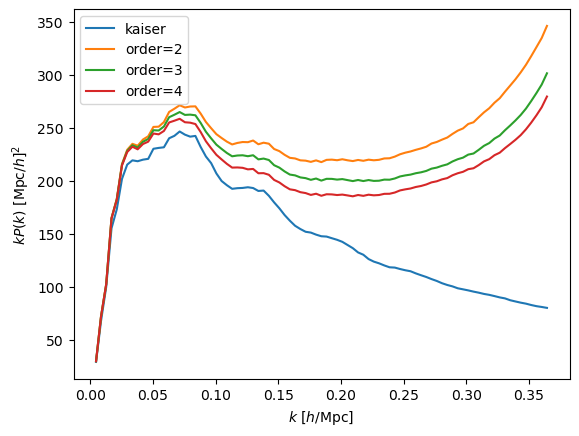

In [ ]:
kpow = model.spectrum(kaimesh)
plot_pow(*kpow, label=f"kaiser")

for i in range(2, 5):
    print(paint_kernels[i](0))
    mesh_lpt = mesh
    pos = upos
    # pos = regpos
    # pos = sobpos
    # mesh_lpt = deconv_paint(mesh_lpt, order=i)
    fac = 0.63033668 if i==3 else 0.555599137 if i==4 else 1.
    dpos, vel = lpt(model.cosmo_fid, mesh_lpt, pos, a=0.5, lpt_order=1, read_order=i)

    delta = paint(pos + dpos, tuple(model.mesh_shape), order=i)
    delta = deconv_paint(delta, order=i)
    kpow = model.spectrum(delta)
    plot_pow(*kpow, label=f"order={i}")
plt.legend();
# plt.savefig("lpt2_readi_regpos_divker0.png", bbox_inches='tight')

In [ ]:
inmesh = jnp.fft.irfftn(mesh)
# inmesh = kaimesh
for i in range(1, 5):
    vals = read(regpos, inmesh, order=i)
    print(vals.mean(), vals.std())
print(inmesh.mean(), inmesh.std())

-1.2727622648717363e-19 1.2186344033595038
-1.2727622648717363e-19 1.2186344033595038
-1.060635220726447e-19 0.7681499595100806
2.121270441452894e-20 0.6770722153949071
-1.2727622648717363e-19 1.2186344033595038


In [ ]:
# inmesh = jnp.fft.irfftn(mesh)
inmesh = kaimesh
for i in range(1, 5):
    vals = read(regpos, inmesh, order=i)
    print(vals.mean(), vals.std())
print(inmesh.mean(), inmesh.std())

1.0 0.7408895085072241
1.0 0.7408895085072241


1.0 0.46700983034152527
1.0 0.411637567021686
1.0 0.7408895085072241


## Interlacing and NUFFT

In [21]:
ids = jnp.arange(5)

def step(carry, i):
    carry += jnp.array([0,1])[i]
    return carry, None

lax.scan(step, 0., ids)

(Array(4., dtype=float64, weak_type=True), None)

In [ ]:
from montecosmo.bricks import lin_power_mesh, regular_pos, kaiser_model, Planck18
from montecosmo.nbody import paint, read, deconv_paint, lpt, paint_kernels, interlace
from montecosmo.utils import rfftk, r2chshape
from itertools import product
box_shape = np.array(3*(3000,))


def forward(l, box_shape, interlace_order:int=1, deconv=False, paint_order:int=2):
    ptcl_shape = np.array((l,l,l))
    mesh_shape = np.array((l,l,l))
    cosmo_fid = Planck18()

    mesh = jr.normal(jr.key(0), mesh_shape)
    pmesh = lin_power_mesh(cosmo_fid, mesh_shape, box_shape)
    mesh = jnp.fft.rfftn(mesh) * pmesh**.5
    pos = regular_pos(mesh_shape, ptcl_shape)

    dpos, vel = lpt(cosmo_fid, mesh, pos, a=0.5, lpt_order=1, read_order=1)

    gxy_mesh = interlace2(pos + dpos, mesh_shape, 1., paint_order, interlace_order)
    # gxy_mesh = paint(pos + dpos, tuple(mesh_shape), 1., paint_order)
    # gxy_mesh = jnp.fft.rfftn(gxy_mesh)

    if deconv:
        gxy_mesh = deconv_paint(gxy_mesh, order=paint_order)
    gxy_mesh = jnp.fft.irfftn(gxy_mesh)
    return gxy_mesh




def interlace2(pos, mesh_shape, weights=1., paint_order:int=2, interlace_order:int=2):
    # shifts = jnp.arange(interlace_order) / interlace_order
    shifts = jnp.array([[0,0,0],[0,0,1],[0,1,0],[1,0,0],[1,1,1]]) / 2
    # shifts = jnp.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]) / 2
    kvec = rfftk(mesh_shape)
    carry = jnp.zeros(r2chshape(mesh_shape), dtype='complex')

    def step(carry, shift):
        mesh = paint(pos + shift, tuple(mesh_shape), weights, paint_order)
        # carry += jnp.fft.rfftn(mesh) * jnp.exp(1j * shift * sum(kvec)) / interlace_order
        carry += jnp.fft.rfftn(mesh) * jnp.exp(1j * shift * sum(ki * si for ki, si in zip(kvec, shift))) / len(shifts)
        return carry, None
    
    carry = lax.scan(step, carry, shifts)[0]
    return carry
    # return jnp.fft.irfftn(carry) 



deconv = True
paint_order = 2
# refmesh = jit(partial(forward, l=256, interlace_order=1, deconv=deconv, paint_order=paint_order))(box_shape=box_shape)
refmesh = forward(l=256, box_shape=box_shape, interlace_order=1, deconv=deconv, paint_order=paint_order)
mesh1 = forward(l=128, box_shape=box_shape, interlace_order=1, deconv=deconv, paint_order=paint_order)
mesh2 = forward(l=128, box_shape=box_shape, interlace_order=2, deconv=deconv, paint_order=paint_order)
mesh3 = forward(l=128, box_shape=box_shape, interlace_order=3, deconv=deconv, paint_order=paint_order)

2025-07-05 07:55:07.819887: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


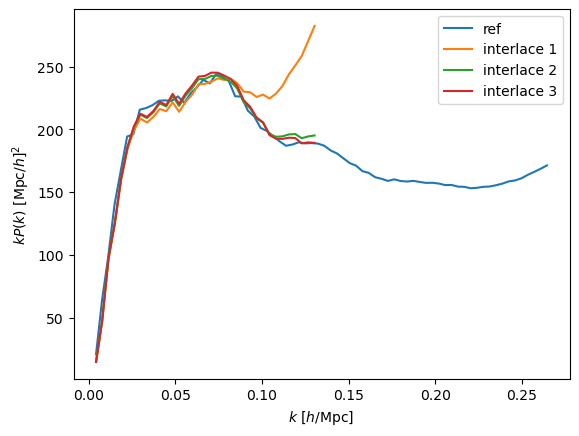

In [4]:
from montecosmo.metrics import spectrum
from montecosmo.plot import plot_pow

kpow_ref = spectrum(refmesh, box_shape=box_shape)
plot_pow(*kpow_ref, label="ref")
kpow1 = spectrum(mesh1, box_shape=box_shape)
plot_pow(*kpow1, label="interlace 1")
kpow2 = spectrum(mesh2, box_shape=box_shape)
plot_pow(*kpow2, label="interlace 2")
kpow3 = spectrum(mesh3, box_shape=box_shape)
plot_pow(*kpow3, label="interlace 3")
plt.legend()

In [ ]:
from montecosmo.bricks import unif_pos
paint_order = 4
l = 64

def paint2(pos, mesh:tuple|jnp.ndarray, weights=1., order:int=2):
    if isinstance(mesh, tuple):
        mesh = jnp.zeros(mesh)
    else:
        mesh = jnp.asarray(mesh)

    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry = carry.at[idx].add(weights * ker)
        return carry, None
    
    mesh = lax.scan(step, mesh, ishifts)[0]
    return mesh


def read2(pos, mesh:tuple|jnp.ndarray, order:int=2):
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry += mesh[idx] * ker
        return carry, None
    
    out = jnp.zeros(id0.shape[:-1])
    out = lax.scan(step, out, ishifts)[0]
    return out

def paint_pos(seed):
    mesh_shape = np.array((l,l,l))
    pos = unif_pos(mesh_shape, mesh_shape, seed)
    mesh = paint(pos, tuple(mesh_shape), 1., paint_order)
    return mesh.std()

def paint2_pos(seed):
    mesh_shape = np.array((l,l,l))
    pos = unif_pos(mesh_shape, mesh_shape, seed)
    mesh = paint2(pos, tuple(mesh_shape), 1., paint_order)
    return mesh.std()

def read_pos(seed):
    pos_seed, mesh_seed = jr.split(seed, 2)
    mesh_shape = np.array((l,l,l))
    pos = unif_pos(mesh_shape, mesh_shape, pos_seed)
    mesh = jr.normal(mesh_seed, mesh_shape)
    out = read(pos, mesh, paint_order)
    return out.std()

def read2_pos(seed):
    pos_seed, mesh_seed = jr.split(seed, 2)
    mesh_shape = np.array((l,l,l))
    pos = unif_pos(mesh_shape, mesh_shape, pos_seed)
    mesh = jr.normal(mesh_seed, mesh_shape)
    out = read2(pos, mesh, paint_order)
    return out.std()

seeds = jr.split(jr.key(0), 10)

In [71]:
%%timeit
out = jit(vmap(paint_pos))(seeds).block_until_ready()
# print(out)

3.02 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
out = jit(vmap(paint2_pos))(seeds).block_until_ready()
# print(out)

158 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%%timeit
out = jit(vmap(read_pos))(seeds).block_until_ready()
# print(out)

5.21 s ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%%timeit
out = jit(vmap(read2_pos))(seeds).block_until_ready()
# print(out)

447 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Kaiser curved-sky

In [ ]:
from montecosmo.nbody import rfftk, a2f
from montecosmo.bricks import tophysical_mesh
from montecosmo.utils import safe_div

init_mesh = truth['init_mesh']
bE = 2.
los, a = tophysical_mesh(model.box_center, model.box_rot, model.box_shape, model.mesh_shape,
                    model.cosmo_fid, model.a_obs, model.curved_sky)

kvec = rfftk(model.mesh_shape)
kmesh = sum(kk**2 for kk in kvec)**.5 # in cell units

mu_delta = jnp.stack([jnp.fft.irfftn(
        safe_div(kvec[i] * init_mesh, kmesh)
        ) for i in range(3)], axis=-1)
mu_delta = (mu_delta * los).sum(-1)
mu_delta = jnp.fft.rfftn(mu_delta)

mu2_delta = jnp.stack([jnp.fft.irfftn(
        safe_div(kvec[i] * mu_delta, kmesh)
        ) for i in range(3)], axis=-1)
mu2_delta = (mu2_delta * los).sum(-1)

delta = (bE * jnp.fft.irfftn(init_mesh) + a2f(model.cosmo_fid, a) * mu2_delta)




from jax.scipy.special import sph_harm
# from jax.scipy.special import sph_harm_y # JAX >= 0.6.1
pos = model.pos_mesh()
mu2_delta = jnp.fft.irfftn(init_mesh) / 3
for m in range(-2, 3):
    def cart2thetaphi(cart):
        x, y, z = jnp.moveaxis(cart, -1, 0)
        theta = jnp.arctan2(y, x) % (2 * np.pi)
        phi = np.pi / 2 - jnp.arcsin(z)
        return theta, phi

    angles_k = 
    angles_los = 
    mu2_delta += 8 * np.pi / 15 * jnp.fft.irfftn(sph_harm(m, 2, *angles_k)) * sph_harm(m, 2, *angles_los).conj()